In [1]:
from dtw import *
import numpy as np
import datetime
import re
import csv
import pandas as pd
import matplotlib.pyplot as plt
import statistics

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# importing the libraries
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.models import load_model

tf.Tensor(-289.8161, shape=(), dtype=float32)


2024-11-26 02:51:24.133537: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# reading your file for Wind data
Wind_read_file = pd.read_csv("WI_H1_SWE_2017.csv", delimiter = ',', comment='#', \
                    parse_dates=[0], infer_datetime_format=True, na_values='-1.00000e+31') #  by convention we call it "df
Wind_read_file = Wind_read_file.rename(columns={Wind_read_file.columns[0]:"Epoch", Wind_read_file.columns[1]:"PROTON_BULK_SPEED", Wind_read_file.columns[2]:"P+_W_NONLIN", Wind_read_file.columns[3]:"P+_DENSITY", Wind_read_file.columns[4]:"BX", Wind_read_file.columns[5]:"BY", Wind_read_file.columns[6]:"BZ"})

Wind_read_file


,Epoch,PROTON_BULK_SPEED,P+_W_NONLIN,P+_DENSITY,BX,BY,BZ
0,2017-01-01 00:01:21.143000+00:00,551.383,56.4392,6.90979,-6.23286,3.663370,-0.618211
1,2017-01-01 00:03:00.041000+00:00,548.496,53.7259,6.90203,-6.38386,2.677510,-1.543220
2,2017-01-01 00:04:38.940000+00:00,553.285,57.2532,7.52417,-5.17778,-3.331740,-3.239950
3,2017-01-01 00:06:17.838000+00:00,568.129,51.5084,7.31016,-3.61870,-4.982880,-3.905190
4,2017-01-01 00:07:56.737000+00:00,550.258,54.0437,6.99562,-5.84033,-1.151720,-3.860940
...,...,...,...,...,...,...,...
302714,2017-12-31 23:50:55.302000+00:00,389.247,54.0795,16.26670,0.74707,-0.888578,-5.844250
302715,2017-12-31 23:52:34.309000+00:00,395.178,43.1694,15.22750,2.03863,-1.143950,-6.759960
302716,2017-12-31 23:54:13.317000+00:00,397.280,38.6794,13.12920,4.09914,-3.528210,-7.518280
302717,2017-12-31 23:55:52.325000+00:00,396.026,38.2271,13.32620,4.87532,-3.791930,-7.872770


In [4]:
Wind_read_file_drop=Wind_read_file.dropna() #deleting nan values
Wind_read_file_drop

,Epoch,PROTON_BULK_SPEED,P+_W_NONLIN,P+_DENSITY,BX,BY,BZ
0,2017-01-01 00:01:21.143000+00:00,551.383,56.4392,6.90979,-6.23286,3.663370,-0.618211
1,2017-01-01 00:03:00.041000+00:00,548.496,53.7259,6.90203,-6.38386,2.677510,-1.543220
2,2017-01-01 00:04:38.940000+00:00,553.285,57.2532,7.52417,-5.17778,-3.331740,-3.239950
3,2017-01-01 00:06:17.838000+00:00,568.129,51.5084,7.31016,-3.61870,-4.982880,-3.905190
4,2017-01-01 00:07:56.737000+00:00,550.258,54.0437,6.99562,-5.84033,-1.151720,-3.860940
...,...,...,...,...,...,...,...
302714,2017-12-31 23:50:55.302000+00:00,389.247,54.0795,16.26670,0.74707,-0.888578,-5.844250
302715,2017-12-31 23:52:34.309000+00:00,395.178,43.1694,15.22750,2.03863,-1.143950,-6.759960
302716,2017-12-31 23:54:13.317000+00:00,397.280,38.6794,13.12920,4.09914,-3.528210,-7.518280
302717,2017-12-31 23:55:52.325000+00:00,396.026,38.2271,13.32620,4.87532,-3.791930,-7.872770


In [5]:
#keeping only values within the right range
Wind_read_file_drop =Wind_read_file_drop[Wind_read_file_drop["P+_DENSITY"].between(0.1, 50)]  #density values
Wind_read_file_drop = Wind_read_file_drop[Wind_read_file_drop["P+_W_NONLIN"].between(10, 150)]  #Temperature values
Wind_read_file_drop = Wind_read_file_drop[Wind_read_file_drop["PROTON_BULK_SPEED"].between(200, 900)]  #speed values

Wind_read_file_drop = Wind_read_file_drop[Wind_read_file_drop["BX"].between(-100, 100)]
Wind_read_file_drop = Wind_read_file_drop[Wind_read_file_drop["BY"].between(-100, 100)]
Wind_read_file_drop = Wind_read_file_drop[Wind_read_file_drop["BZ"].between(-100, 100)]


# -100 < Bx < 100
# -100 < By < 100
# -100 < Bz < 100
# 200 < proton speed < 900
# 10 < proton thermal speed < 150
# 0.1 < proton density < 50


In [6]:
Wind_read_file_drop.to_csv("WI_H1_SWE_2017_final.csv", index=False) # save your new csv file

In [7]:
#reading your new CSV file for Wind data
wdata_read = pd.read_csv("WI_H1_SWE_2017_final.csv", delimiter = ',', comment='#', \
                    parse_dates=[0],infer_datetime_format=True, date_parser=lambda col: pd.to_datetime(col, utc=True),na_values='-1.00000e+31')
wdata_read = wdata_read.rename(columns={wdata_read.columns[0]:"Epoch_time", wdata_read.columns[1]:"Speed", wdata_read.columns[2]:"Temp", wdata_read.columns[3]:"Density", wdata_read.columns[4]:"bx", wdata_read.columns[5]:"by", wdata_read.columns[6]:"bz"})
wdata_read

,Epoch_time,Speed,Temp,Density,bx,by,bz
0,2017-01-01 00:01:21.143000+00:00,551.383,56.4392,6.90979,-6.23286,3.663370,-0.618211
1,2017-01-01 00:03:00.041000+00:00,548.496,53.7259,6.90203,-6.38386,2.677510,-1.543220
2,2017-01-01 00:04:38.940000+00:00,553.285,57.2532,7.52417,-5.17778,-3.331740,-3.239950
3,2017-01-01 00:06:17.838000+00:00,568.129,51.5084,7.31016,-3.61870,-4.982880,-3.905190
4,2017-01-01 00:07:56.737000+00:00,550.258,54.0437,6.99562,-5.84033,-1.151720,-3.860940
...,...,...,...,...,...,...,...
285956,2017-12-31 23:50:55.302000+00:00,389.247,54.0795,16.26670,0.74707,-0.888578,-5.844250
285957,2017-12-31 23:52:34.309000+00:00,395.178,43.1694,15.22750,2.03863,-1.143950,-6.759960
285958,2017-12-31 23:54:13.317000+00:00,397.280,38.6794,13.12920,4.09914,-3.528210,-7.518280
285959,2017-12-31 23:55:52.325000+00:00,396.026,38.2271,13.32620,4.87532,-3.791930,-7.872770


In [8]:
#reading DSCOVR data
ddata_read = pd.read_csv("dsc_fc_summed_spectra_2017_v01.csv", delimiter = ',', comment='#', \
                  parse_dates=[0], infer_datetime_format=True, na_values='-1.00000e+31')


In [9]:
zero_mask = (((ddata_read.iloc[:,4:54]).values) == 0).all(axis=1)

ddata_to_filter = ddata_read[~zero_mask]
ddata_to_filter

,2017-01-01 00:00:00,-4.17863,-4.51183,-3.52434,0,0.1,0.2,0.3,0.4,0.5,...,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30
0,2017-01-01 00:01:00,-6.06788,-0.379552,-3.49708,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 00:02:00,-5.83430,-3.039940,-2.98546,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 00:03:00,-5.87318,-3.352910,-2.77476,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-01 00:04:00,-5.81431,-3.305190,-2.59870,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-01 00:05:00,-6.23986,-3.240720,-1.01048,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525594,2017-12-31 23:55:00,6.07246,-3.402390,-4.20657,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525595,2017-12-31 23:56:00,6.94467,-3.434060,-4.33012,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525596,2017-12-31 23:57:00,7.04210,-1.602740,-5.85800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525597,2017-12-31 23:58:00,6.74641,0.337871,-6.33095,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
wdata_read = wdata_read.resample('160s', on='Epoch_time').median()

wdata = wdata_read.interpolate(method="linear")  #interpolating to fill in data gaps in Wind data
wdata

,Speed,Temp,Density,bx,by,bz
Epoch_time,,,,,,
2017-01-01 00:00:00+00:00,551.3830,56.43920,6.909790,-6.232860,3.663370,-0.618211
2017-01-01 00:02:40+00:00,550.8905,55.48955,7.213100,-5.780820,-0.327115,-2.391585
2017-01-01 00:05:20+00:00,559.1935,52.77605,7.152890,-4.729515,-3.067300,-3.883065
2017-01-01 00:08:00+00:00,550.6040,55.52160,7.671590,-5.797990,-2.731430,-3.537750
2017-01-01 00:10:40+00:00,551.8050,53.21985,7.028765,-5.739440,-3.250100,-3.133550
...,...,...,...,...,...,...
2017-12-31 23:46:40+00:00,391.1725,44.63585,14.160100,2.752630,-3.058350,-7.148715
2017-12-31 23:49:20+00:00,389.2470,54.07950,16.266700,0.747070,-0.888578,-5.844250
2017-12-31 23:52:00+00:00,396.2290,40.92440,14.178350,3.068885,-2.336080,-7.139120


In [11]:
ddata_read_drop=ddata_to_filter.dropna() #deleting nan values

In [12]:
ddata_read_drop

,2017-01-01 00:00:00,-4.17863,-4.51183,-3.52434,0,0.1,0.2,0.3,0.4,0.5,...,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30
0,2017-01-01 00:01:00,-6.06788,-0.379552,-3.49708,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 00:02:00,-5.83430,-3.039940,-2.98546,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 00:03:00,-5.87318,-3.352910,-2.77476,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-01 00:04:00,-5.81431,-3.305190,-2.59870,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-01 00:05:00,-6.23986,-3.240720,-1.01048,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525594,2017-12-31 23:55:00,6.07246,-3.402390,-4.20657,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525595,2017-12-31 23:56:00,6.94467,-3.434060,-4.33012,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525596,2017-12-31 23:57:00,7.04210,-1.602740,-5.85800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525597,2017-12-31 23:58:00,6.74641,0.337871,-6.33095,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
ddata_read_drop = ddata_read_drop.rename(columns={ddata_read_drop.columns[0]:"t", ddata_read_drop.columns[1]:"bx", ddata_read_drop.columns[2]:"by",ddata_read_drop.columns[3]:"bz"})
ddata_read_drop = ddata_read_drop.resample('160s', on='t').median()
ddata_read_drop

,bx,by,bz,0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30
t,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-5.951090,-1.709746,-3.241270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:02:40,-5.873180,-3.305190,-2.598700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:05:20,-5.737460,-3.549605,-2.038740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:08:00,-5.741180,-2.831990,-3.252300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:10:40,-5.658680,-2.894970,-3.115560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 23:46:40,4.976460,-4.971770,-5.477130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 23:49:20,2.926140,-3.184660,-6.830780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 23:52:00,2.161340,-1.924160,-3.708310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
ddata = ddata_read_drop.interpolate(method="linear") #interpolation for DSCOVR data
ddata

,bx,by,bz,0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30
t,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-5.951090,-1.709746,-3.241270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:02:40,-5.873180,-3.305190,-2.598700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:05:20,-5.737460,-3.549605,-2.038740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:08:00,-5.741180,-2.831990,-3.252300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:10:40,-5.658680,-2.894970,-3.115560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 23:46:40,4.976460,-4.971770,-5.477130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 23:49:20,2.926140,-3.184660,-6.830780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 23:52:00,2.161340,-1.924160,-3.708310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
wdata

,Speed,Temp,Density,bx,by,bz
Epoch_time,,,,,,
2017-01-01 00:00:00+00:00,551.3830,56.43920,6.909790,-6.232860,3.663370,-0.618211
2017-01-01 00:02:40+00:00,550.8905,55.48955,7.213100,-5.780820,-0.327115,-2.391585
2017-01-01 00:05:20+00:00,559.1935,52.77605,7.152890,-4.729515,-3.067300,-3.883065
2017-01-01 00:08:00+00:00,550.6040,55.52160,7.671590,-5.797990,-2.731430,-3.537750
2017-01-01 00:10:40+00:00,551.8050,53.21985,7.028765,-5.739440,-3.250100,-3.133550
...,...,...,...,...,...,...
2017-12-31 23:46:40+00:00,391.1725,44.63585,14.160100,2.752630,-3.058350,-7.148715
2017-12-31 23:49:20+00:00,389.2470,54.07950,16.266700,0.747070,-0.888578,-5.844250
2017-12-31 23:52:00+00:00,396.2290,40.92440,14.178350,3.068885,-2.336080,-7.139120


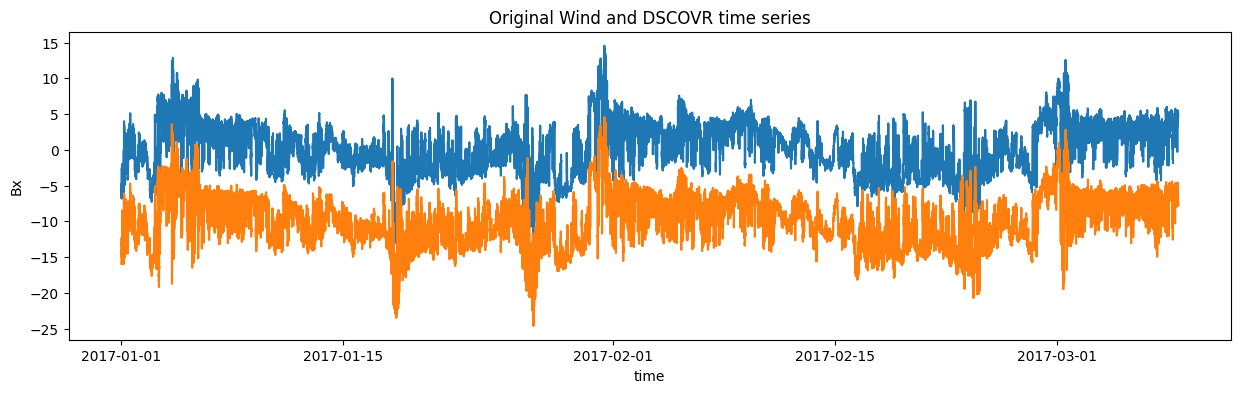

In [16]:
# Plot the two time series pre-warping. They look very similar already
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(4)

plt.plot(wdata['bx'][0:36000])  #only selecting few months of data for now
plt.title('Original Wind and DSCOVR time series')
plt.xlabel('time')
plt.ylabel('Bx')
plt.plot(ddata['bx'][0:36000]-10)


In [17]:
#reading DSCOVR data
ddata_read_science = pd.read_csv("DSCOVR_H1_FC_2017_nvT_1minute.csv", delimiter = ',',index_col=False, comment='#', \
                  parse_dates=[0], infer_datetime_format=True, na_values='-1.00000e+31')
ddata_read_science


,EPOCH__yyyy-mm-ddThh:mm:ss.sssZ,wp,np,vp
0,2017-01-01 00:00:00+00:00,55.8827,6.41355,548.235
1,2017-01-01 00:01:00+00:00,49.2905,5.81441,533.246
2,2017-01-01 00:02:00+00:00,50.0845,6.11847,536.926
3,2017-01-01 00:03:00+00:00,49.9076,6.16366,537.169
4,2017-01-01 00:04:00+00:00,49.6466,5.99470,536.550
...,...,...,...,...
516955,2017-12-31 23:54:59+00:00,42.7539,16.78620,400.728
516956,2017-12-31 23:56:00+00:00,42.3851,16.45130,401.399
516957,2017-12-31 23:57:01+00:00,38.9540,16.52870,400.209
516958,2017-12-31 23:57:59+00:00,38.7463,16.11450,402.689


In [18]:
ddata_read_science_drop=ddata_read_science.dropna() #deleting nan values
ddata_read_science_drop

,EPOCH__yyyy-mm-ddThh:mm:ss.sssZ,wp,np,vp
0,2017-01-01 00:00:00+00:00,55.8827,6.41355,548.235
1,2017-01-01 00:01:00+00:00,49.2905,5.81441,533.246
2,2017-01-01 00:02:00+00:00,50.0845,6.11847,536.926
3,2017-01-01 00:03:00+00:00,49.9076,6.16366,537.169
4,2017-01-01 00:04:00+00:00,49.6466,5.99470,536.550
...,...,...,...,...
516955,2017-12-31 23:54:59+00:00,42.7539,16.78620,400.728
516956,2017-12-31 23:56:00+00:00,42.3851,16.45130,401.399
516957,2017-12-31 23:57:01+00:00,38.9540,16.52870,400.209
516958,2017-12-31 23:57:59+00:00,38.7463,16.11450,402.689


In [19]:
ddata_read_science_drop = ddata_read_science_drop.rename(columns={ddata_read_science_drop.columns[0]:"epoch", ddata_read_science_drop.columns[1]:"wp", ddata_read_science_drop.columns[2]:"np", ddata_read_science_drop.columns[3]:"vp"})
ddata_read_science_drop

,epoch,wp,np,vp
0,2017-01-01 00:00:00+00:00,55.8827,6.41355,548.235
1,2017-01-01 00:01:00+00:00,49.2905,5.81441,533.246
2,2017-01-01 00:02:00+00:00,50.0845,6.11847,536.926
3,2017-01-01 00:03:00+00:00,49.9076,6.16366,537.169
4,2017-01-01 00:04:00+00:00,49.6466,5.99470,536.550
...,...,...,...,...
516955,2017-12-31 23:54:59+00:00,42.7539,16.78620,400.728
516956,2017-12-31 23:56:00+00:00,42.3851,16.45130,401.399
516957,2017-12-31 23:57:01+00:00,38.9540,16.52870,400.209
516958,2017-12-31 23:57:59+00:00,38.7463,16.11450,402.689


In [20]:
ddata_read_science_drop = ddata_read_science_drop.resample('160s', on='epoch').median()#.bfill()
ddata_science = ddata_read_science_drop.interpolate(method="linear") #interpolation for DSCOVR data
ddata_science

,wp,np,vp
epoch,,,
2017-01-01 00:00:00+00:00,50.08450,6.11847,536.9260
2017-01-01 00:02:40+00:00,49.64660,5.99470,536.5500
2017-01-01 00:05:20+00:00,49.63445,5.88859,536.8850
2017-01-01 00:08:00+00:00,48.93990,5.64802,535.7550
2017-01-01 00:10:40+00:00,49.98810,5.77130,536.1600
...,...,...,...
2017-12-31 23:46:40+00:00,45.96960,15.88040,390.9050
2017-12-31 23:49:20+00:00,45.99665,15.56725,388.2120
2017-12-31 23:52:00+00:00,50.29290,16.02590,389.4080


## first step: Dynamic Time Warping

In [21]:
def DTW_function(wdata_input, ddata_input, start_index, end_index):
 
    query1_ = wdata_input.bx.values[start_index:end_index]  #WIND
    #query2 = adata.bx.values[0:3599]  #ACE
    template_ = ddata_input.bx.values[start_index:end_index] #DSCOVR as reference


    ## Find the best match with the canonical recursion formula
    alignment_wd_ = dtw(query1_, template_, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))
    #alignment_ad = dtw(query2, template, keep_internals=True)

    ## Display the warping curve, i.e. the alignment curve
    #alignment_wd_plot=alignment_wd.plot(type="threeway", xlab='Wind time base in minutes', ylab='DSCOVR time base in minutes', main='PLot title')
    #alignment_ad.plot(type="threeway")

    ## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion...
    # not that I have any idea what that is. It was the default in the tutorial

    #dtw_map=dtw(query1, template, keep_internals=True, 
        #step_pattern=rabinerJuangStepPattern(6, "c")).plot(type="twoway",xlab='nT', ylab='nT DSC',offset=-10) #blue color is the reference(DSCOVR in this case) 

    #dtw(query2, template, keep_internals=True, 
        #step_pattern=rabinerJuangStepPattern(6, "c")).plot(type="twoway",offset=-10) 

    ## See the recursion relation, as formula and diagram
    #print(rabinerJuangStepPattern(6,"c"))
    #rabinerJuangStepPattern(6,"c").plot()
    ind = warp(alignment_wd_,index_reference=False)  #indexing here #which is the indexing from the dtw part above
    
    return query1_, template_, alignment_wd_, ind

In [22]:
query1, template, alignment_wd, ind_Jan_Feb=DTW_function(wdata, ddata, 0, 36000)

Text(0.5, 1.0, 'Wind and DSCOVR Bx time series pre-warping')

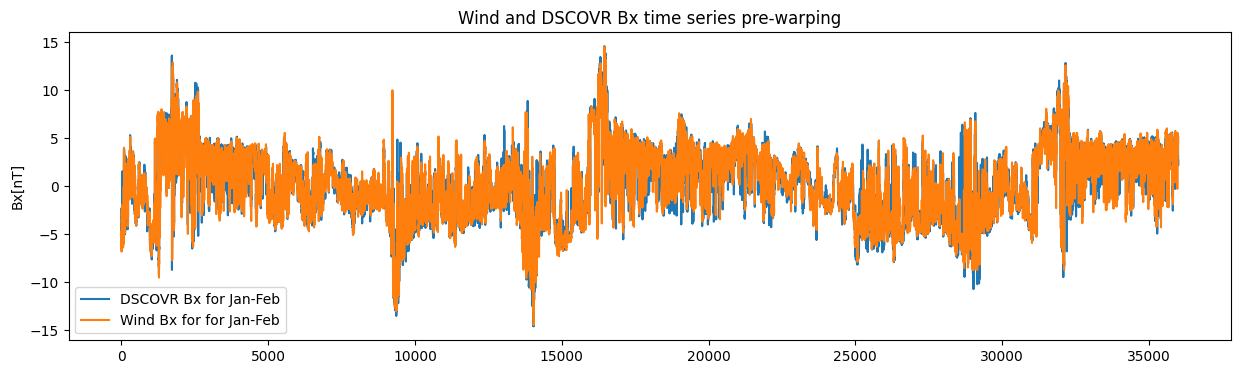

In [23]:
# plot the original Bx time series data all on top of each other
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(4)
plt.plot(template, label='DSCOVR Bx for Jan-Feb')
plt.plot(query1, label='Wind Bx for for Jan-Feb')
#plt.plot(query2)
plt.ylabel('Bx[nT]')
plt.legend()
plt.title('Wind and DSCOVR Bx time series pre-warping')

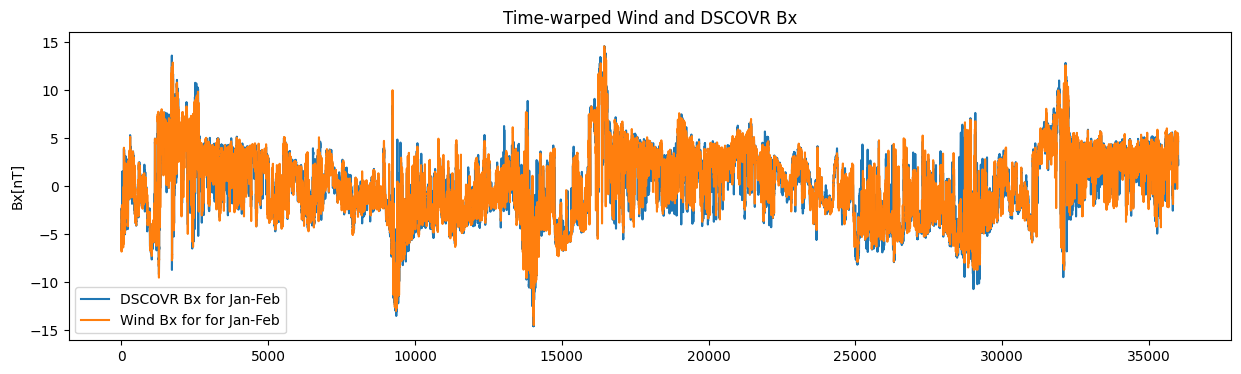

In [24]:
#replot the previous, with time warped version
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(4)
plt.plot(template, label='DSCOVR Bx for Jan-Feb') #DSCOVR
plt.plot(query1[ind_Jan_Feb], label='Wind Bx for for Jan-Feb') #Wind time-warped
plt.title('Time-warped Wind and DSCOVR Bx')
plt.legend()
#plt.plot(query2[ind2])
#plt.xlabel('time')
plt.ylabel('Bx[nT]')
plt.show()

## second step: time warping

In [25]:
def warp_function(wdata_input, ind):
    
    Wind_density_=wdata_input['Density']
    Wind_Temp_=wdata_input['Temp']
    Wind_speed_=wdata_input['Speed']

    
    warped_density_=Wind_density_[ind]  
    warped_temp_=Wind_Temp_[ind]
    warped_speed_=Wind_speed_[ind]
    return warped_density_, warped_temp_, warped_speed_

In [26]:
warped_density_Jan_Feb, warped_temp_Jan_Feb, warped_speed_Jan_Feb=warp_function(wdata, ind_Jan_Feb)

## Final step: Neural Network model

In [27]:
# importing the libraries
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.models import load_model

tf.Tensor(568.32104, shape=(), dtype=float32)


In [28]:
def input_prep_func(ddata_input, warped_temp, index_start, index_end):
    X = (ddata_input.iloc[:,3:53]).values  #DSCOVR data columns 3:53 as the X input
    Y = np.transpose([warped_temp]) #warped wind as the y input


    DSCOVR_input_=X[index_start:(index_end),:]  #DSCOVR selecting a smaller chunk to work with, Jan-Feb
    Wind_input_=Y[index_start:index_end]
    return DSCOVR_input_, Wind_input_

In [29]:
DSCOVR_input_Jan_Feb, Wind_input_Jan_Feb=input_prep_func(ddata, warped_temp_Jan_Feb, 0, 36000)

In [30]:
def standardization_func(DSCOVR_input,  Wind_input):

    PredictorScaler=StandardScaler()
    TargetVarScaler=StandardScaler()

    # Storing the fit object for later reference
    PredictorScalerFit_=PredictorScaler.fit(DSCOVR_input)
    TargetVarScalerFit_=TargetVarScaler.fit(Wind_input)

    # Generating the standardized values of DSCOVR_input and Wind_input
    DSCOVR_input_final=PredictorScalerFit_.transform(DSCOVR_input)
    Wind_input_final=TargetVarScalerFit_.transform(Wind_input)

    # Split the data into training and testing set
    
    DSCOVR_input_train, DSCOVR_input_test, Wind_input_train, Wind_input_test = train_test_split(DSCOVR_input_final, Wind_input_final, test_size=0.3, random_state=42)

    # Quick sanity check with the shapes of Training and testing datasets
    print(DSCOVR_input_train.shape)
    print(Wind_input_train.shape)
    print(DSCOVR_input_test.shape)
    print(Wind_input_test.shape)
    
    return PredictorScalerFit_, TargetVarScalerFit_, DSCOVR_input_final, Wind_input_final, DSCOVR_input_train, DSCOVR_input_test, Wind_input_train, Wind_input_test

In [31]:
PredictorScalerFit, TargetVarScalerFit, DSCOVR_input_Jan_Feb_final, Wind_input_Jan_Feb_final, DSCOVR_input_train_Jan_Feb, DSCOVR_input_test_Jan_Feb, Wind_input_train_Jan_Feb, Wind_input_test_Jan_Feb=standardization_func(DSCOVR_input_Jan_Feb, Wind_input_Jan_Feb)

(25200, 50)
(25200, 1)
(10800, 50)
(10800, 1)


In [32]:
import tensorflow as tf
import tensorflow_probability as tfp
#from tf_agents.environments import tf_py_environment

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_datasets as tfds
import tensorflow_probability as tfp

In [33]:
tfd = tfp.distributions


# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=0.1*t, scale=0.1),
            reinterpreted_batch_ndims=1)),
    ])

   
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


import tensorflow as tf
import tensorflow_probability as tfp
#from tf_agents.environments import tf_py_environment

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_datasets as tfds
import tensorflow_probability as tfp

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=0.1 * tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

# Alias for TensorFlow Probability layers and distributions
tfd = tfp.distributions
tfpl = tfp.layers

def pareto_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model
def pareto_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    initial_loc = tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.01)  # Slightly higher mean
    initial_scale = tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.01)  # Slightly higher mean

    posterior_model = keras.Sequential(
        [
            tfpl.VariableLayer(
                2 * n, dtype=dtype,
                initializer=lambda shape, dtype: tf.concat(
                    [
                        initial_loc(shape=(n,), dtype=dtype),
                        initial_scale(shape=(n,), dtype=dtype)
                    ],
                    axis=-1
                )
            ),
            tfpl.DistributionLambda(
                lambda t: tfd.Independent(
                    tfd.Pareto(
                        concentration=tf.nn.softplus(t[..., :n]) + 1.5,  # Ensure alpha > 1
                        scale=tf.nn.softplus(t[..., n:]) + 1.0  # Ensure x_m > 0
                    ),
                    reinterpreted_batch_ndims=1
                )
            )
        ]
    )
    return posterior_model


In [34]:
from tensorflow.keras.layers import LayerNormalization

def create_bnn_model(train_size):
    inputs = layers.Input(shape=(50,), dtype=tf.float32)  # Assuming input shape is (25199, 50)
    #normalized_inputs = tf.keras.layers.BatchNormalization()(inputs)

    hidden_units = [8, 8]  # Define your hidden units here

    x=inputs
    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        #normalized_inputs = tf.keras.layers.BatchNormalization()(normalized_inputs)
        x = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior_trainable,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation=tf.keras.activations.softplus   #smooth relu
            #activation='relu' 
            #activation = tf.keras.activations.relu  
            #activation = tf.keras.layers.LeakyReLU(alpha=0.1)  # LeakyReLU
        )(x)
    x=LayerNormalization()(x)
    
    distribution_params = layers.Dense(units=2)(x)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [35]:
num_epochs = 50
train_size=int(DSCOVR_input_train_Jan_Feb.shape[0])
input_shape = DSCOVR_input_train_Jan_Feb.shape[1:]

#bnn_model_full = create_bnn_model(train_size)
bnn_model_full_Jan_Feb= create_bnn_model(train_size)

2024-11-26 02:54:15.577549: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## negative loglikelihood loss

In [36]:
import tensorflow as tf

def simple_penalized_nll(targets, estimated_distribution, threshold=1, min_val=1, max_val=850):
    # Basic NLL calculation
    base_nll = -estimated_distribution.log_prob(targets)
   
    # Penalize if mean of predicted distribution is below threshold
    mean_predictions = estimated_distribution.mean()
    penalized_nll = tf.where(mean_predictions < threshold, base_nll ** 2, base_nll)

    # Clamp final NLL to be within [min_val, max_val]
    constrained_nll = tf.clip_by_value(penalized_nll, min_val, max_val)

    # Return the mean NLL over all data points
    return tf.reduce_mean(penalized_nll)

In [37]:
import tensorflow as tf

def improved_penalized_nll(targets, estimated_distribution, threshold=1, min_val=1, max_val=850):
    """
    Penalized Negative Log-Likelihood (NLL) Loss Function
    Args:
        targets: Ground truth values.
        estimated_distribution: Predicted distribution (e.g., mean and variance).
        threshold: Minimum acceptable mean prediction before applying penalties.
        min_val: Minimum valid target value to avoid numerical instability.
        max_val: Maximum valid target value to normalize penalties.
   
    Returns:
        Penalized NLL loss.
    """
    # Calculate the base negative log-likelihood
    base_nll = -estimated_distribution.log_prob(targets)

    # Extract the mean of the predicted distribution
    mean_predictions = estimated_distribution.mean()

    # Penalize underestimation (mean below targets)
    underestimation_penalty = tf.where(
        mean_predictions < targets,  # Penalize predictions lower than targets
        tf.math.abs(mean_predictions - targets) ** 2,  # Quadratic penalty for underestimation
        tf.zeros_like(base_nll)  # No penalty for accurate or overestimating predictions
    )

    # Normalize the penalty to avoid excessively large loss values
    scaled_penalty = underestimation_penalty / (max_val - min_val)

    # Combine the base NLL with the scaled penalty
    total_loss = base_nll + scaled_penalty

    # Return the mean loss over all data points
    return tf.reduce_mean(total_loss)


In [38]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [39]:
def peak_penalized_nll(targets, estimated_distribution, peak_threshold=600):
    base_nll = -estimated_distribution.log_prob(targets)
    mean_predictions = estimated_distribution.mean()

    # Penalize underestimation in high peaks
    underestimation_penalty = tf.where(
        (mean_predictions < targets) & (targets > peak_threshold),
        tf.math.abs(mean_predictions - targets) ** 2,
        tf.zeros_like(base_nll)
    )

    return tf.reduce_mean(base_nll + underestimation_penalty)

In [40]:
def run_experiment(bnn_model_full, DSCOVR_input_train_Jan_Feb, Wind_input_train_Jan_Feb):  
    bnn_model_full.compile(
            optimizer=keras.optimizers.Adam(),
            loss='peak_penalized_nll'
            #, metrics=
            , metrics=['mae', 'mse']
        )
    
    
    # Train the model
    print("Start training the model...")
    bnn_model_full.fit(DSCOVR_input_train_Jan_Feb, Wind_input_train_Jan_Feb, epochs=num_epochs, batch_size=20,  verbose=1)
    print("Model training finished.")
    # Assuming you have loaded your test data into variables DSCOVR_input_test_Jan_Feb and Wind_input_test_Jan_Feb

    #bnn_model_full.save('bnn_model_full')
    
    #bnn_model_full_trained = load_model('bnn_model_full')


    #return bnn_model_full_trained

# Register custom loss function
tf.keras.utils.get_custom_objects()['simple_penalized_nll'] = simple_penalized_nll

tf.keras.utils.get_custom_objects()['improved_penalized_nll'] = improved_penalized_nll

# Register custom loss function
tf.keras.utils.get_custom_objects()['negative_loglikelihood'] = negative_loglikelihood

tf.keras.utils.get_custom_objects()['peak_penalized_nll'] = peak_penalized_nll

## Training on Jan-Feb data

In [41]:
run_experiment(bnn_model_full_Jan_Feb, DSCOVR_input_train_Jan_Feb, Wind_input_train_Jan_Feb)

#bnn_model_full_Jan_Feb=run_experiment(bnn_model_full, DSCOVR_input_train_Jan_Feb, Wind_input_train_Jan_Feb)

Start training the model...
Epoch 1/50


2024-11-26 02:54:16.183951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1260/1260 [==============================] - 9s 3ms/step - loss: 2.8025 - mae: 1.2799 - mse: 2.5999
Epoch 2/50
1260/1260 [==============================] - 3s 3ms/step - loss: 2.2219 - mae: 1.1743 - mse: 2.1808
Epoch 3/50
1260/1260 [==============================] - 4s 3ms/step - loss: 2.0128 - mae: 1.1243 - mse: 1.9725
Epoch 4/50
1260/1260 [==============================] - 2s 2ms/step - loss: 1.8305 - mae: 1.1284 - mse: 1.9926
Epoch 5/50
1260/1260 [==============================] - 2s 1ms/step - loss: 1.5040 - mae: 0.9628 - mse: 1.5115
Epoch 6/50
1260/1260 [==============================] - 2s 1ms/step - loss: 1.1521 - mae: 0.7181 - mse: 0.8621
Epoch 7/50
1260/1260 [==============================] - 2s 2ms/step - loss: 1.0275 - mae: 0.6630 - mse: 0.7465
Epoch 8/50
1260/1260 [==============================] - 2s 1ms/step - loss: 0.9325 - mae: 0.6342 - mse: 0.6917
Epoch 9/50
1260/1260 [==============================] - 2s 1ms/step - loss: 0.8591 - mae: 0.6027 - mse: 0.6323
Epoch 10/50


## Evaluation on March

In [42]:
def non_warped_values_func(wdata_input):
    
    Wind_density_=wdata_input['Density']
    Wind_Temp_=wdata_input['Temp']
    Wind_speed_=wdata_input['Speed']

    return Wind_density_, Wind_Temp_, Wind_speed_

In [43]:
Wind_density, Wind_Temp, Wind_speed=non_warped_values_func(wdata)

DSCOVR_input_March, Wind_input_March=input_prep_func(ddata, Wind_Temp.values, 36000, 49000)
query1_March, template_March, alignment_wd_March, ind_March=DTW_function(wdata, ddata, 36000, 49000)
Wind_input_March_warped_=Wind_input_March[ind_March]

In [44]:
DSCOVR_input_March_final=PredictorScalerFit.transform(DSCOVR_input_March)

In [45]:
prediction_distribution_March = bnn_model_full_Jan_Feb(DSCOVR_input_March_final)
prediction_mean_March = prediction_distribution_March.mean().numpy().tolist()
prediction_stdv_March = prediction_distribution_March.stddev().numpy()


Predictions_March_ = TargetVarScalerFit.inverse_transform(prediction_mean_March)
Predictions_March_[0:5]

array([[47.42026333],
       [46.97201137],
       [47.74321576],
       [48.16629688],
       [47.63420259]])

## Confidence Interval

In [46]:
prediction_stdv_March_=prediction_stdv_March*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_March = (Predictions_March_ + (1.96 * prediction_stdv_March_)).tolist()
lower_March = (Predictions_March_ - (1.96 * prediction_stdv_March_)).tolist()
prediction_stdv_March_ = prediction_stdv_March_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_March_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_March_[idx][0], 2)}, "
        f"95% CI: [{round(upper_March[idx][0], 2)} - {round(lower_March[idx][0], 2)}]"
        f" - Actual: {Wind_input_March_warped_[idx]}"
    )


Prediction mean: 47.42, stddev: 6.02, 95% CI: [59.23 - 35.61] - Actual: [49.55175]
Prediction mean: 46.97, stddev: 5.94, 95% CI: [58.62 - 35.32] - Actual: [47.9118]
Prediction mean: 47.74, stddev: 6.11, 95% CI: [59.72 - 35.77] - Actual: [48.18205]
Prediction mean: 48.17, stddev: 6.21, 95% CI: [60.35 - 35.99] - Actual: [51.1348]
Prediction mean: 47.63, stddev: 5.91, 95% CI: [59.22 - 36.05] - Actual: [47.1763]
Prediction mean: 47.87, stddev: 6.07, 95% CI: [59.77 - 35.98] - Actual: [47.1763]
Prediction mean: 47.56, stddev: 5.91, 95% CI: [59.14 - 35.99] - Actual: [50.8648]
Prediction mean: 48.6, stddev: 6.2, 95% CI: [60.76 - 36.44] - Actual: [51.2943]
Prediction mean: 49.24, stddev: 6.37, 95% CI: [61.71 - 36.76] - Actual: [51.2943]
Prediction mean: 47.79, stddev: 6.12, 95% CI: [59.79 - 35.79] - Actual: [51.0532]


## Confidence Interval plot

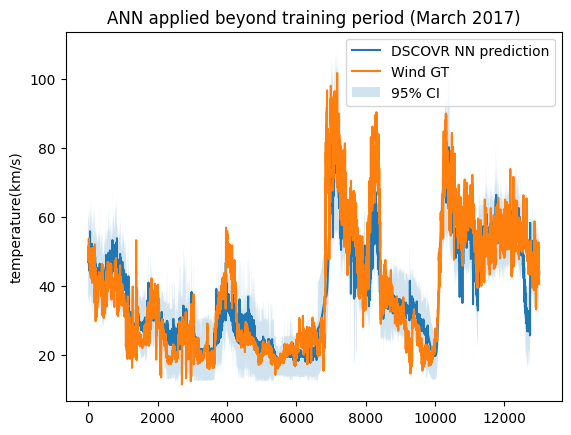

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_March_flat = np.ravel(upper_March)
lower_March_flat = np.ravel(lower_March)

# Plotting predictions
plt.plot(Predictions_March_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_March_)), upper_March_flat, lower_March_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_March_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (March 2017)')
plt.ylabel('temperature(km/s)')
plt.legend()
#plt.savefig('CI_temperature_March_DSCOVR_NN_prediction_and_Wind_GT_2017_2.png')
plt.show()


In [48]:
mask_March=(Predictions_March_ >= 1) & (Predictions_March_<=120)
Predictions_March=Predictions_March_[mask_March]
Wind_input_March_warped=Wind_input_March_warped_[mask_March]

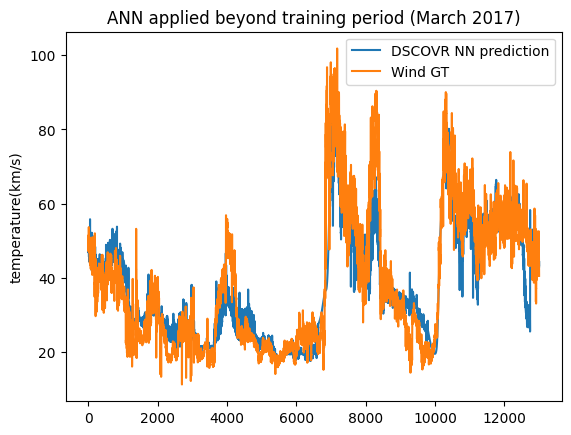

In [49]:
plt.plot(Predictions_March, label='DSCOVR NN prediction')
#plt.plot(Wind_input_March_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_March_warped, label='Wind GT')
plt.title('ANN applied beyond training period (March 2017)')
#plt.savefig('temperature_March_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

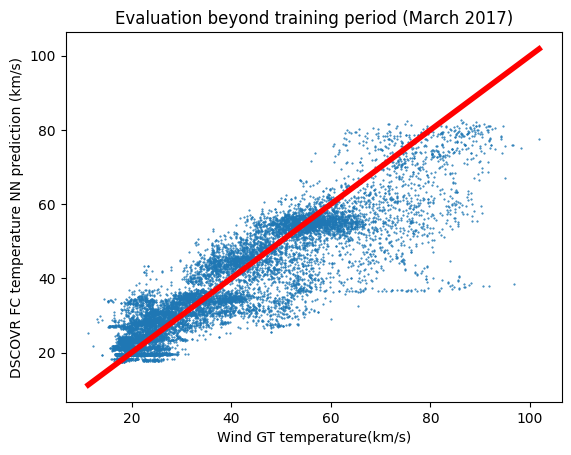

In [50]:
plt.plot(Wind_input_March_warped, Predictions_March, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (March 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped)],[np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped)], color='red', linewidth=4)
#plt.savefig('temperature-March_prediction_2017.png')

Mean err %:  5.5760410771763045
Median err %:  4.001626092684738
stddev: 7.9707995641555724


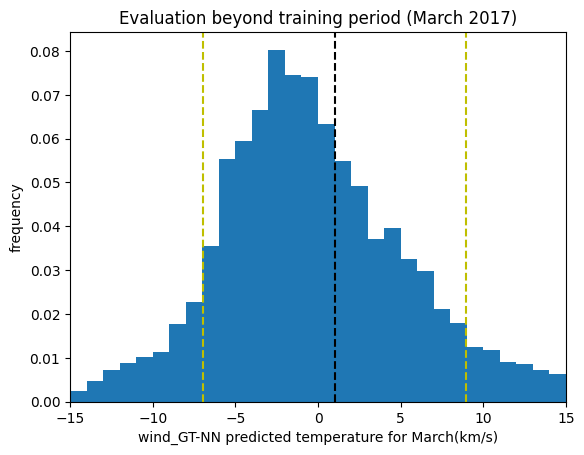

In [51]:
perr_NN_March = 100.*(Wind_input_March_warped-Predictions_March)/Wind_input_March_warped
tk_NN_March=np.where(Wind_input_March_warped > 0.1)
arr_perr_NN_March = (perr_NN_March)[tk_NN_March]
arr_regular_NN_March=(Wind_input_March_warped-Predictions_March)
m_NN_March=np.mean((arr_regular_NN_March))
sd_NN_March=np.std((arr_regular_NN_March))


plt.hist(arr_regular_NN_March, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_March, color='k', linestyle='dashed')
plt.axvline(m_NN_March+sd_NN_March, color='y', linestyle='dashed')
plt.axvline(m_NN_March-sd_NN_March, color='y', linestyle='dashed')

plt.xlim(-15,15)
#plt.yscale('log')
plt.title('Evaluation beyond training period (March 2017)')
plt.xlabel('wind_GT-NN predicted temperature for March(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-March_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_March)))
print('Median err %: ', np.median(abs(arr_regular_NN_March)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_March)

## April

In [52]:
Wind_input_March_warped=Wind_input_March_warped.reshape(-1,1)
Wind_input_March_warped_final=TargetVarScalerFit.transform(Wind_input_March_warped)

mask_March_flat = mask_March.flatten()

# Now use the flattened mask for indexing
DSCOVR_input_March_final = DSCOVR_input_March_final[mask_March_flat]

In [53]:
DSCOVR_input_April, Wind_input_April=input_prep_func(ddata, Wind_Temp.values, 49000, 65000)
query1_April, template_April, alignment_wd_April, ind_April=DTW_function(wdata, ddata, 49000, 65000)
Wind_input_April_warped_=Wind_input_April[ind_April]

In [54]:
# Generating the standardized values of DSCOVR_input and Wind_input for April
DSCOVR_input_April_final=PredictorScalerFit.transform(DSCOVR_input_April)
#Wind_input_April_warped_final=TargetVarScalerFit.transform(Wind_input_April_warped)

In [55]:
prediction_distribution_April = bnn_model_full_Jan_Feb(DSCOVR_input_April_final)
prediction_mean_April = prediction_distribution_April.mean().numpy().tolist()
prediction_stdv_April = prediction_distribution_April.stddev().numpy()


Predictions_April_ = TargetVarScalerFit.inverse_transform(prediction_mean_April)
Predictions_April_

array([[45.64352788],
       [45.6427416 ],
       [46.38943512],
       ...,
       [28.69053991],
       [28.65961061],
       [28.60978817]])

In [56]:
prediction_stdv_April_=prediction_stdv_April*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_April = (Predictions_April_ + (1.96 * prediction_stdv_April_)).tolist()
lower_April = (Predictions_April_ - (1.96 * prediction_stdv_April_)).tolist()
prediction_stdv_April_ = prediction_stdv_April_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_April_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_April_[idx][0], 2)}, "
        f"95% CI: [{round(upper_April[idx][0], 2)} - {round(lower_April[idx][0], 2)}]"
        f" - Actual: {Wind_input_April_warped_[idx]}"
    )


Prediction mean: 45.64, stddev: 5.15, 95% CI: [55.74 - 35.55] - Actual: [45.5138]
Prediction mean: 45.64, stddev: 5.54, 95% CI: [56.49 - 34.79] - Actual: [45.7639]
Prediction mean: 46.39, stddev: 5.59, 95% CI: [57.34 - 35.44] - Actual: [44.0337]
Prediction mean: 46.21, stddev: 5.18, 95% CI: [56.37 - 36.05] - Actual: [45.04885]
Prediction mean: 47.09, stddev: 5.27, 95% CI: [57.42 - 36.77] - Actual: [39.9584]
Prediction mean: 46.5, stddev: 5.21, 95% CI: [56.72 - 36.28] - Actual: [40.49475]
Prediction mean: 46.29, stddev: 5.19, 95% CI: [56.47 - 36.11] - Actual: [42.28705]
Prediction mean: 46.54, stddev: 5.22, 95% CI: [56.77 - 36.32] - Actual: [39.2104]
Prediction mean: 46.25, stddev: 5.2, 95% CI: [56.44 - 36.06] - Actual: [41.62635]
Prediction mean: 46.23, stddev: 5.2, 95% CI: [56.42 - 36.04] - Actual: [41.62635]


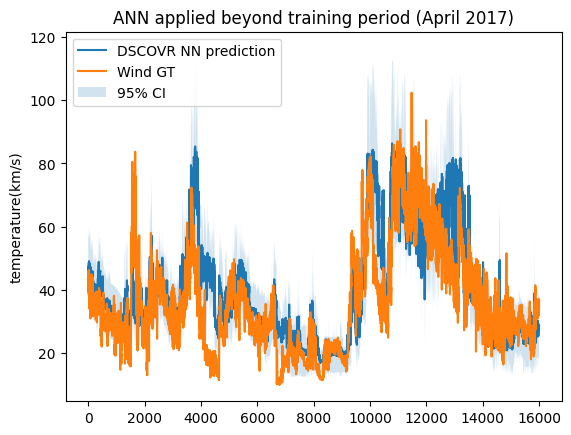

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_April_flat = np.ravel(upper_April)
lower_April_flat = np.ravel(lower_April)




# Plotting predictions
plt.plot(Predictions_April_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_April_)), upper_April_flat, lower_April_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_April_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (April 2017)')
plt.ylabel('temperature(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_temperature_April_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [58]:
mask_April=(Predictions_April_ >= 1) & (Predictions_April_<=120)
Predictions_April=Predictions_April_[mask_April]
Wind_input_April_warped=Wind_input_April_warped_[mask_April]

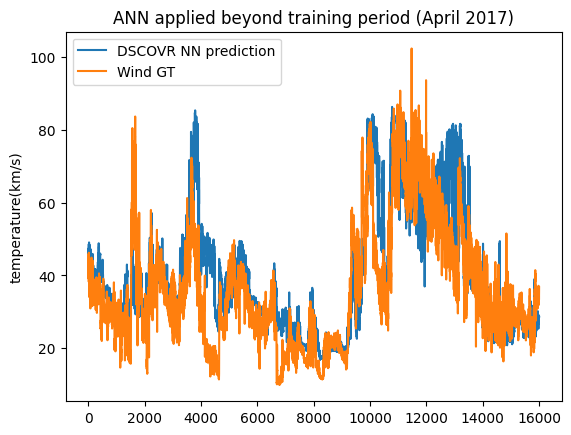

In [59]:
plt.plot(Predictions_April, label='DSCOVR NN prediction')
#plt.plot(Wind_input_April_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_April_warped, label='Wind GT')
plt.title('ANN applied beyond training period (April 2017)')
#plt.savefig('temperature_April_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

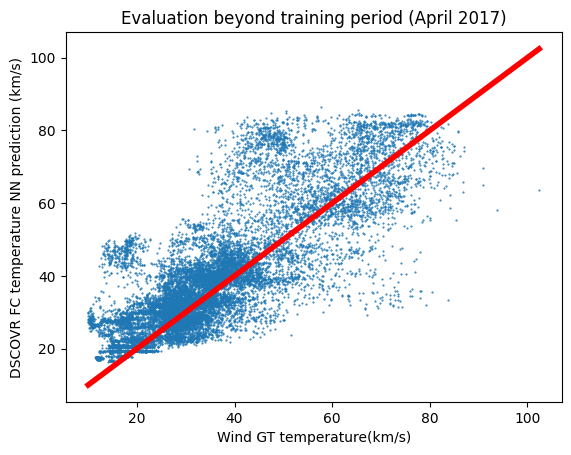

In [60]:
plt.plot(Wind_input_April_warped, Predictions_April, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (April 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_April_warped), np.amax(Wind_input_April_warped)],[np.amin(Wind_input_April_warped), np.amax(Wind_input_April_warped)], color='red', linewidth=4)
#plt.savefig('temperature-March_prediction_2017.png')

Mean err %:  7.880112053682887
Median err %:  5.37203870151933
stddev: 10.37289848271806


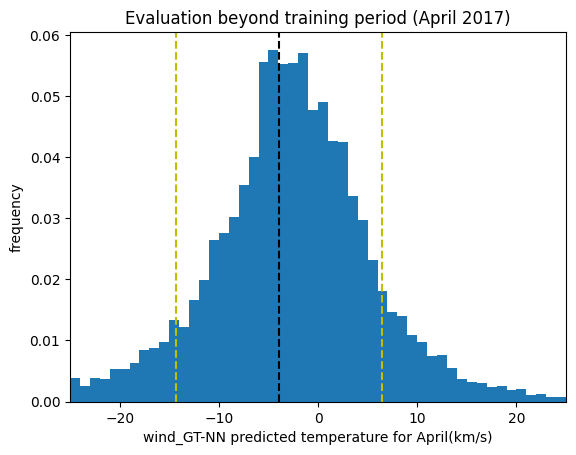

In [61]:
perr_NN_April = 100.*(Wind_input_April_warped-Predictions_April)/Wind_input_April_warped
tk_NN_April=np.where(Wind_input_April_warped > 0.1)
arr_perr_NN_April = (perr_NN_April)[tk_NN_April]
arr_regular_NN_April=(Wind_input_April_warped-Predictions_April)
m_NN_April=np.mean((arr_regular_NN_April))
sd_NN_April=np.std((arr_regular_NN_April))


plt.hist(arr_regular_NN_April, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_April, color='k', linestyle='dashed')
plt.axvline(m_NN_April+sd_NN_April, color='y', linestyle='dashed')
plt.axvline(m_NN_April-sd_NN_April, color='y', linestyle='dashed')

plt.xlim(-25,25)
#plt.yscale('log')
plt.title('Evaluation beyond training period (April 2017)')
plt.xlabel('wind_GT-NN predicted temperature for April(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-April_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_April)))
print('Median err %: ', np.median(abs(arr_regular_NN_April)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_April)

## May

In [62]:
DSCOVR_input_May, Wind_input_May=input_prep_func(ddata, Wind_Temp.values, 65000, 81000)
query1_May, template_May, alignment_wd_May, ind_May=DTW_function(wdata, ddata, 65000, 81000)
Wind_input_May_warped_=Wind_input_May[ind_May]

# Generating the standardized values of DSCOVR_input and Wind_input for May
DSCOVR_input_May_final=PredictorScalerFit.transform(DSCOVR_input_May)
#Wind_input_May_warped_final=TargetVarScalerFit.transform(Wind_input_May_warped)


prediction_distribution_May = bnn_model_full_Jan_Feb(DSCOVR_input_May_final)
prediction_mean_May = prediction_distribution_May.mean().numpy().tolist()
prediction_stdv_May = prediction_distribution_May.stddev().numpy()


Predictions_May_ = TargetVarScalerFit.inverse_transform(prediction_mean_May)
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
#Wind_input_test_orig_March = TargetVarScalerFit.inverse_transform(Wind_input_March_warped_2)
#Test_Data_March = PredictorScalerFit.inverse_transform(DSCOVR_input_March_final)


mask_May=((Predictions_May_ >= 1)&(Predictions_May_ <= 120))
Predictions_May=Predictions_May_[mask_May]
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
Wind_input_May_warped=Wind_input_May_warped_[mask_May]

In [63]:
prediction_stdv_May_=prediction_stdv_May*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_May = (Predictions_May_ + (1.96 * prediction_stdv_May_)).tolist()
lower_May = (Predictions_May_ - (1.96 * prediction_stdv_May_)).tolist()
prediction_stdv_May_ = prediction_stdv_May_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_May_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_May_[idx][0], 2)}, "
        f"95% CI: [{round(upper_May[idx][0], 2)} - {round(lower_May[idx][0], 2)}]"
        f" - Actual: {Wind_input_May_warped_[idx]}"
    )




Prediction mean: 26.19, stddev: 4.58, 95% CI: [35.17 - 17.21] - Actual: [35.4741]
Prediction mean: 26.17, stddev: 4.58, 95% CI: [35.16 - 17.19] - Actual: [33.66245]
Prediction mean: 26.06, stddev: 4.56, 95% CI: [35.0 - 17.13] - Actual: [34.24015]
Prediction mean: 25.79, stddev: 4.31, 95% CI: [34.24 - 17.34] - Actual: [35.5735]
Prediction mean: 26.19, stddev: 4.58, 95% CI: [35.16 - 17.22] - Actual: [35.5735]
Prediction mean: 25.74, stddev: 4.11, 95% CI: [33.79 - 17.69] - Actual: [34.76965]
Prediction mean: 25.64, stddev: 4.09, 95% CI: [33.66 - 17.61] - Actual: [36.3977]
Prediction mean: 26.39, stddev: 4.62, 95% CI: [35.45 - 17.34] - Actual: [34.4836]
Prediction mean: 25.39, stddev: 5.24, 95% CI: [35.65 - 15.13] - Actual: [34.28595]
Prediction mean: 26.45, stddev: 4.6, 95% CI: [35.46 - 17.44] - Actual: [37.181]


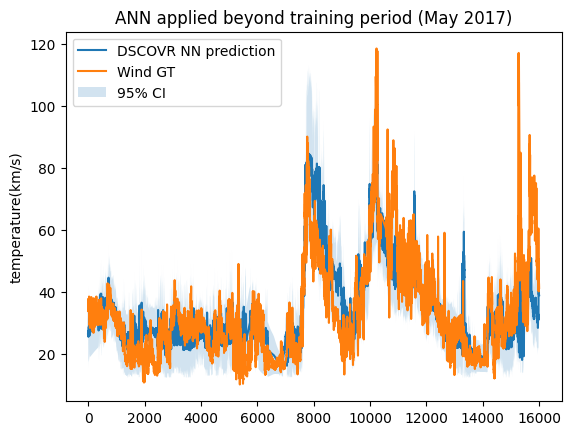

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_May_flat = np.ravel(upper_May)
lower_May_flat = np.ravel(lower_May)

# Plotting predictions
plt.plot(Predictions_May_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_May_)), upper_May_flat, lower_May_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_May_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (May 2017)')
plt.ylabel('temperature(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_temperature_May_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [65]:
mask_May=(Predictions_May_ >= 1) & (Predictions_May_<=120)
Predictions_May=Predictions_May_[mask_May]
Wind_input_May_warped=Wind_input_May_warped_[mask_May]

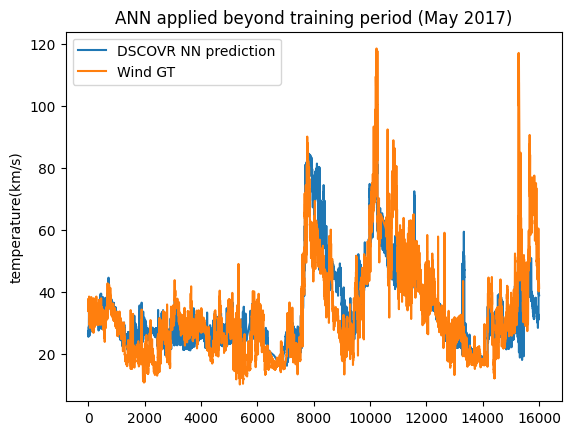

In [66]:
plt.plot(Predictions_May, label='DSCOVR NN prediction')
#plt.plot(Wind_input_May_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_May_warped, label='Wind GT')
plt.title('ANN applied beyond training period (May 2017)')
#plt.savefig('temperature_May_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

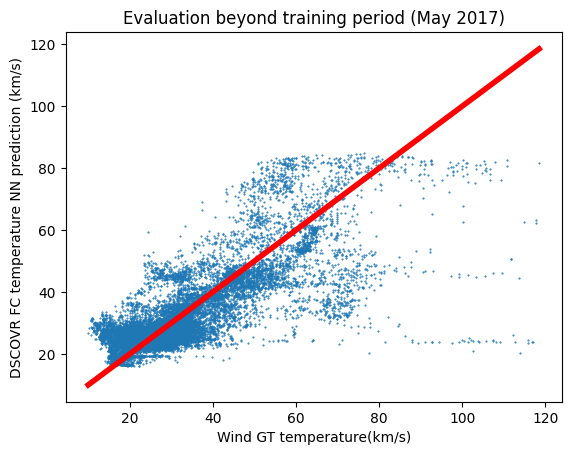

In [67]:
plt.plot(Wind_input_May_warped, Predictions_May, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (May 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_May_warped), np.amax(Wind_input_May_warped)],[np.amin(Wind_input_May_warped), np.amax(Wind_input_May_warped)], color='red', linewidth=4)
#plt.savefig('temperature-May_prediction_2017.png')

Mean err %:  6.782522023208237
Median err %:  4.662150628595679
stddev: 10.154125159439703


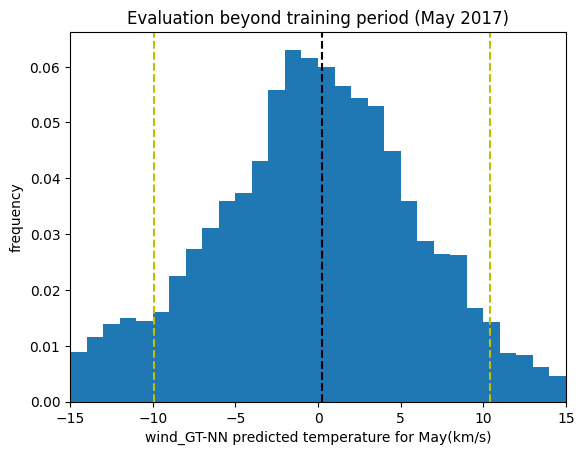

In [68]:
perr_NN_May = 100.*(Wind_input_May_warped-Predictions_May)/Wind_input_May_warped
tk_NN_May=np.where(Wind_input_May_warped > 0.1)
arr_perr_NN_May = (perr_NN_May)[tk_NN_May]
arr_regular_NN_May=(Wind_input_May_warped-Predictions_May)
m_NN_May=np.mean((arr_regular_NN_May))
sd_NN_May=np.std((arr_regular_NN_May))


plt.hist(arr_regular_NN_May, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_May, color='k', linestyle='dashed')
plt.axvline(m_NN_May+sd_NN_May, color='y', linestyle='dashed')
plt.axvline(m_NN_May-sd_NN_May, color='y', linestyle='dashed')

plt.xlim(-15,15)
#plt.yscale('log')
plt.title('Evaluation beyond training period (May 2017)')
plt.xlabel('wind_GT-NN predicted temperature for May(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-May_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_May)))
print('Median err %: ', np.median(abs(arr_regular_NN_May)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_May)

# June

In [69]:
DSCOVR_input_June, Wind_input_June=input_prep_func(ddata, Wind_Temp.values, 81000, 98000)
query1_June, template_June, alignment_wd_June, ind_June=DTW_function(wdata, ddata, 81000, 98000)
Wind_input_June_warped_=Wind_input_June[ind_June]

# Generating the standardized values of DSCOVR_input and Wind_input for June
DSCOVR_input_June_final=PredictorScalerFit.transform(DSCOVR_input_June)
#Wind_input_June_warped_final=TargetVarScalerFit.transform(Wind_input_June_warped)


prediction_distribution_June = bnn_model_full_Jan_Feb(DSCOVR_input_June_final)
prediction_mean_June = prediction_distribution_June.mean().numpy().tolist()
prediction_stdv_June = prediction_distribution_June.stddev().numpy()


Predictions_June_ = TargetVarScalerFit.inverse_transform(prediction_mean_June)
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
#Wind_input_test_orig_March = TargetVarScalerFit.inverse_transform(Wind_input_March_warped_2)
#Test_Data_March = PredictorScalerFit.inverse_transform(DSCOVR_input_March_final)


mask_June=((Predictions_June_ >= 1)&(Predictions_June_ <= 120))
Predictions_June=Predictions_June_[mask_June]
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
Wind_input_June_warped=Wind_input_June_warped_[mask_June]

In [70]:
prediction_stdv_June_=prediction_stdv_June*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_June = (Predictions_June_ + (1.96 * prediction_stdv_June_)).tolist()
lower_June = (Predictions_June_ - (1.96 * prediction_stdv_June_)).tolist()
prediction_stdv_June_ = prediction_stdv_June_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_June_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_June_[idx][0], 2)}, "
        f"95% CI: [{round(upper_June[idx][0], 2)} - {round(lower_June[idx][0], 2)}]"
        f" - Actual: {Wind_input_June_warped_[idx]}"
    )




Prediction mean: 37.94, stddev: 4.92, 95% CI: [47.59 - 28.29] - Actual: [43.86178]
Prediction mean: 37.84, stddev: 4.92, 95% CI: [47.47 - 28.2] - Actual: [46.55596]
Prediction mean: 37.8, stddev: 4.92, 95% CI: [47.44 - 28.16] - Actual: [49.25014]
Prediction mean: 37.9, stddev: 4.92, 95% CI: [47.54 - 28.26] - Actual: [51.94432]
Prediction mean: 37.89, stddev: 4.92, 95% CI: [47.53 - 28.25] - Actual: [52.8317375]
Prediction mean: 37.88, stddev: 4.92, 95% CI: [47.52 - 28.24] - Actual: [51.024975]
Prediction mean: 37.92, stddev: 4.92, 95% CI: [47.56 - 28.28] - Actual: [49.2182125]
Prediction mean: 38.06, stddev: 4.92, 95% CI: [47.7 - 28.42] - Actual: [47.41145]
Prediction mean: 37.96, stddev: 4.91, 95% CI: [47.59 - 28.34] - Actual: [43.797925]
Prediction mean: 37.88, stddev: 4.91, 95% CI: [47.51 - 28.25] - Actual: [41.9911625]


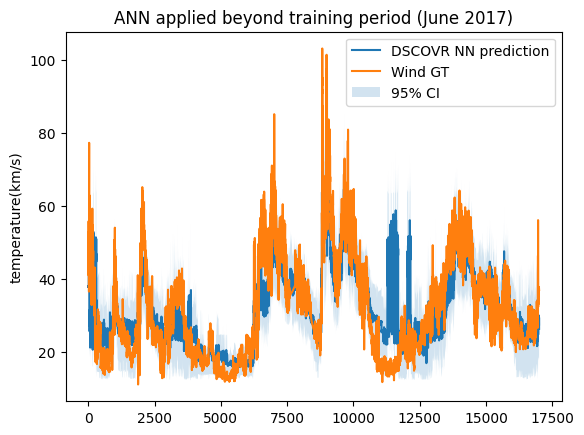

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_June_flat = np.ravel(upper_June)
lower_June_flat = np.ravel(lower_June)

# Plotting predictions
plt.plot(Predictions_June_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_June_)), upper_June_flat, lower_June_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_June_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (June 2017)')
plt.ylabel('temperature(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_temperature_June_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [72]:
mask_June=(Predictions_June_ >= 1) & (Predictions_June_<=120)
Predictions_June=Predictions_June_[mask_June]
Wind_input_June_warped=Wind_input_June_warped_[mask_June]

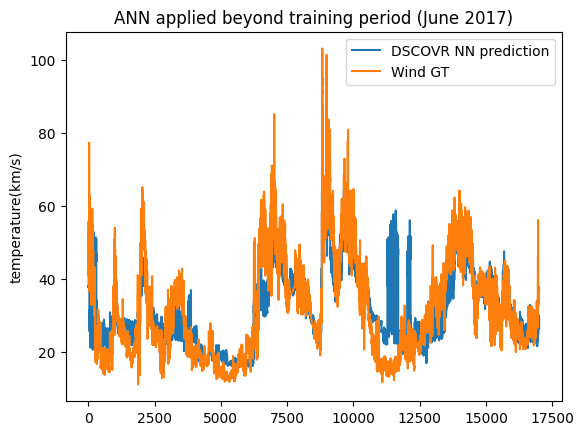

In [73]:
plt.plot(Predictions_June, label='DSCOVR NN prediction')
#plt.plot(Wind_input_June_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_June_warped, label='Wind GT')
plt.title('ANN applied beyond training period (June 2017)')
#plt.savefig('temperature_June_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

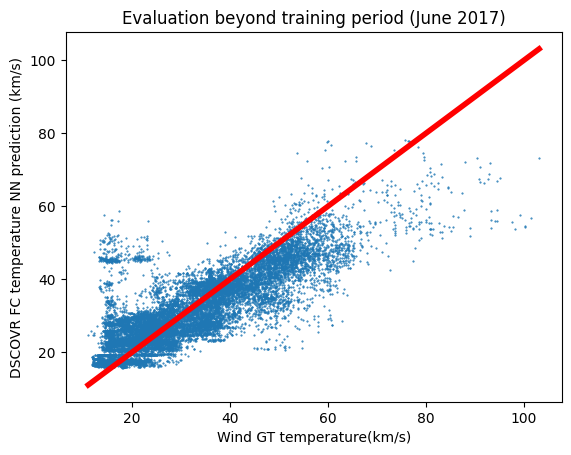

In [74]:
plt.plot(Wind_input_June_warped, Predictions_June, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (June 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_June_warped), np.amax(Wind_input_June_warped)],[np.amin(Wind_input_June_warped), np.amax(Wind_input_June_warped)], color='red', linewidth=4)
#plt.savefig('temperature-June_prediction_2017.png')

Mean err %:  5.690248950342951
Median err %:  4.18215552369891
stddev: 7.999875514319805


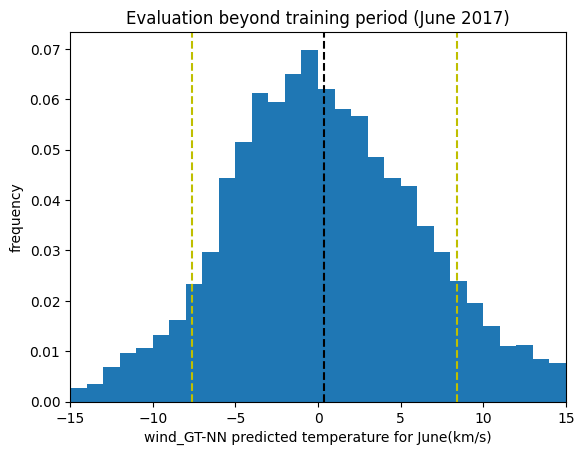

In [75]:
perr_NN_June = 100.*(Wind_input_June_warped-Predictions_June)/Wind_input_June_warped
tk_NN_June=np.where(Wind_input_June_warped > 0.1)
arr_perr_NN_June = (perr_NN_June)[tk_NN_June]
arr_regular_NN_June=(Wind_input_June_warped-Predictions_June)
m_NN_June=np.mean((arr_regular_NN_June))
sd_NN_June=np.std((arr_regular_NN_June))


plt.hist(arr_regular_NN_June, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_June, color='k', linestyle='dashed')
plt.axvline(m_NN_June+sd_NN_June, color='y', linestyle='dashed')
plt.axvline(m_NN_June-sd_NN_June, color='y', linestyle='dashed')

plt.xlim(-15,15)
#plt.yscale('log')
plt.title('Evaluation beyond training period (June 2017)')
plt.xlabel('wind_GT-NN predicted temperature for June(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-June_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_June)))
print('Median err %: ', np.median(abs(arr_regular_NN_June)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_June)

# July

In [76]:
DSCOVR_input_July, Wind_input_July=input_prep_func(ddata, Wind_Temp.values, 98000, 114000)
query1_July, template_July, alignment_wd_July, ind_July=DTW_function(wdata, ddata, 98000, 114000)
Wind_input_July_warped_=Wind_input_July[ind_July]

# Generating the standardized values of DSCOVR_input and Wind_input for July
DSCOVR_input_July_final=PredictorScalerFit.transform(DSCOVR_input_July)
#Wind_input_July_warped_final=TargetVarScalerFit.transform(Wind_input_July_warped)


prediction_distribution_July = bnn_model_full_Jan_Feb(DSCOVR_input_July_final)
prediction_mean_July = prediction_distribution_July.mean().numpy().tolist()
prediction_stdv_July = prediction_distribution_July.stddev().numpy()


Predictions_July_ = TargetVarScalerFit.inverse_transform(prediction_mean_July)
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
#Wind_input_test_orig_March = TargetVarScalerFit.inverse_transform(Wind_input_March_warped_2)
#Test_Data_March = PredictorScalerFit.inverse_transform(DSCOVR_input_March_final)


mask_July=((Predictions_July_ >= 1)&(Predictions_July_ <= 120))
Predictions_July=Predictions_July_[mask_July]
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
Wind_input_July_warped=Wind_input_July_warped_[mask_July]

In [77]:
prediction_stdv_July_=prediction_stdv_July*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_July = (Predictions_July_ + (1.96 * prediction_stdv_July_)).tolist()
lower_July = (Predictions_July_ - (1.96 * prediction_stdv_July_)).tolist()
prediction_stdv_July_ = prediction_stdv_July_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_July_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_July_[idx][0], 2)}, "
        f"95% CI: [{round(upper_July[idx][0], 2)} - {round(lower_July[idx][0], 2)}]"
        f" - Actual: {Wind_input_July_warped_[idx]}"
    )




Prediction mean: 28.36, stddev: 5.22, 95% CI: [38.6 - 18.13] - Actual: [57.07255]
Prediction mean: 27.08, stddev: 5.2, 95% CI: [37.27 - 16.9] - Actual: [48.885]
Prediction mean: 26.99, stddev: 5.19, 95% CI: [37.16 - 16.82] - Actual: [40.69745]
Prediction mean: 27.97, stddev: 5.57, 95% CI: [38.88 - 17.06] - Actual: [32.5099]
Prediction mean: 29.06, stddev: 5.99, 95% CI: [40.79 - 17.33] - Actual: [31.9429]
Prediction mean: 27.15, stddev: 5.21, 95% CI: [37.36 - 16.95] - Actual: [32.71183]
Prediction mean: 28.41, stddev: 5.23, 95% CI: [38.66 - 18.15] - Actual: [32.51786]
Prediction mean: 27.12, stddev: 5.19, 95% CI: [37.3 - 16.94] - Actual: [32.32389]
Prediction mean: 29.0, stddev: 5.13, 95% CI: [39.06 - 18.94] - Actual: [32.32389]
Prediction mean: 28.03, stddev: 5.18, 95% CI: [38.17 - 17.89] - Actual: [32.12992]


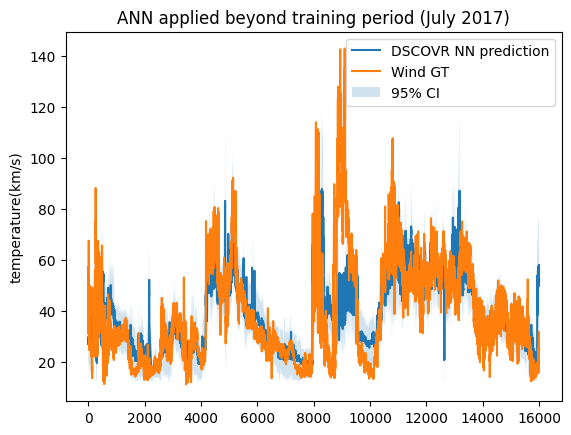

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_July_flat = np.ravel(upper_July)
lower_July_flat = np.ravel(lower_July)

# Plotting predictions
plt.plot(Predictions_July_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_July_)), upper_July_flat, lower_July_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_July_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (July 2017)')
plt.ylabel('temperature(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_temperature_July_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [79]:
mask_July=(Predictions_July_ >= 1) & (Predictions_July_<=120)
Predictions_July=Predictions_July_[mask_July]
Wind_input_July_warped=Wind_input_July_warped_[mask_July]

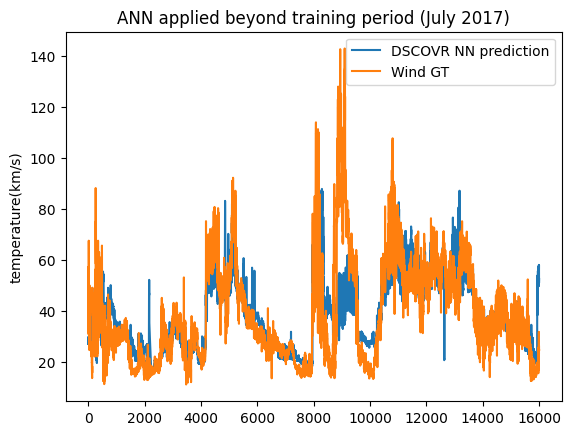

In [80]:
plt.plot(Predictions_July, label='DSCOVR NN prediction')
#plt.plot(Wind_input_July_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_July_warped, label='Wind GT')
plt.title('ANN applied beyond training period (July 2017)')
#plt.savefig('temperature_July_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

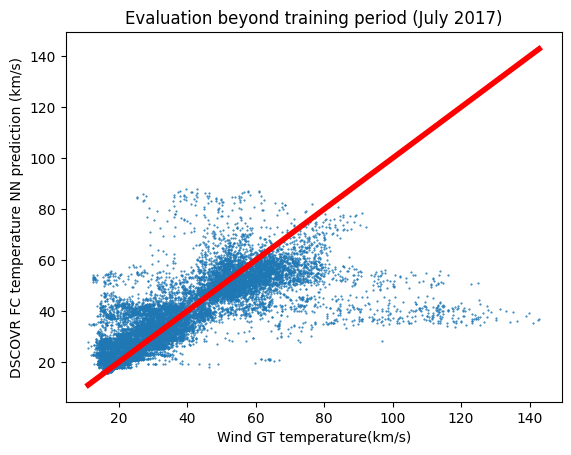

In [81]:
plt.plot(Wind_input_July_warped, Predictions_July, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (July 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_July_warped), np.amax(Wind_input_July_warped)],[np.amin(Wind_input_July_warped), np.amax(Wind_input_July_warped)], color='red', linewidth=4)
#plt.savefig('temperature-July_prediction_2017.png')

Mean err %:  7.977959009892045
Median err %:  4.883747383056409
stddev: 13.390249572349369


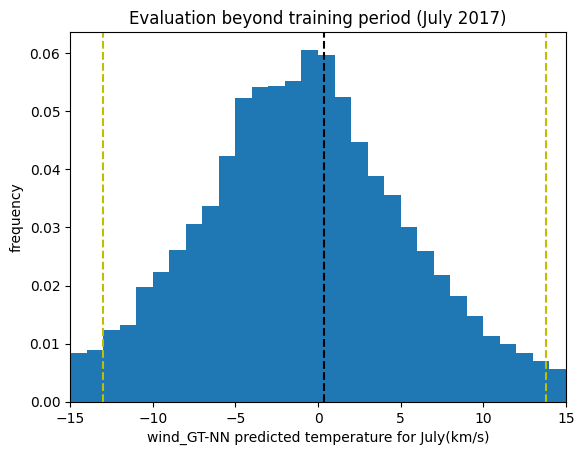

In [82]:
perr_NN_July = 100.*(Wind_input_July_warped-Predictions_July)/Wind_input_July_warped
tk_NN_July=np.where(Wind_input_July_warped > 0.1)
arr_perr_NN_July = (perr_NN_July)[tk_NN_July]
arr_regular_NN_July=(Wind_input_July_warped-Predictions_July)
m_NN_July=np.mean((arr_regular_NN_July))
sd_NN_July=np.std((arr_regular_NN_July))


plt.hist(arr_regular_NN_July, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_July, color='k', linestyle='dashed')
plt.axvline(m_NN_July+sd_NN_July, color='y', linestyle='dashed')
plt.axvline(m_NN_July-sd_NN_July, color='y', linestyle='dashed')

plt.xlim(-15,15)
#plt.yscale('log')
plt.title('Evaluation beyond training period (July 2017)')
plt.xlabel('wind_GT-NN predicted temperature for July(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-July_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_July)))
print('Median err %: ', np.median(abs(arr_regular_NN_July)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_July)

# August

In [83]:
DSCOVR_input_August, Wind_input_August=input_prep_func(ddata, Wind_Temp.values, 114000, 131000)
query1_August, template_August, alignment_wd_August, ind_August=DTW_function(wdata, ddata, 114000, 131000)
Wind_input_August_warped_=Wind_input_August[ind_August]

# Generating the standardized values of DSCOVR_input and Wind_input for August
DSCOVR_input_August_final=PredictorScalerFit.transform(DSCOVR_input_August)
#Wind_input_August_warped_final=TargetVarScalerFit.transform(Wind_input_August_warped)


prediction_distribution_August = bnn_model_full_Jan_Feb(DSCOVR_input_August_final)
prediction_mean_August = prediction_distribution_August.mean().numpy().tolist()
prediction_stdv_August = prediction_distribution_August.stddev().numpy()


Predictions_August_ = TargetVarScalerFit.inverse_transform(prediction_mean_August)
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
#Wind_input_test_orig_March = TargetVarScalerFit.inverse_transform(Wind_input_March_warped_2)
#Test_Data_March = PredictorScalerFit.inverse_transform(DSCOVR_input_March_final)


mask_August=((Predictions_August_ >= 1)&(Predictions_August_ <= 120))
Predictions_August=Predictions_August_[mask_August]
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
Wind_input_August_warped=Wind_input_August_warped_[mask_August]

In [84]:
prediction_stdv_August_=prediction_stdv_August*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_August = (Predictions_August_ + (1.96 * prediction_stdv_August_)).tolist()
lower_August = (Predictions_August_ - (1.96 * prediction_stdv_August_)).tolist()
prediction_stdv_August_ = prediction_stdv_August_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_August_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_August_[idx][0], 2)}, "
        f"95% CI: [{round(upper_August[idx][0], 2)} - {round(lower_August[idx][0], 2)}]"
        f" - Actual: {Wind_input_August_warped_[idx]}"
    )




Prediction mean: 57.79, stddev: 8.99, 95% CI: [75.4 - 40.18] - Actual: [27.33115]
Prediction mean: 55.34, stddev: 9.18, 95% CI: [73.34 - 37.34] - Actual: [25.22]
Prediction mean: 51.64, stddev: 9.13, 95% CI: [69.53 - 33.75] - Actual: [25.9029]
Prediction mean: 54.99, stddev: 9.39, 95% CI: [73.4 - 36.59] - Actual: [25.9029]
Prediction mean: 54.87, stddev: 9.34, 95% CI: [73.17 - 36.57] - Actual: [25.357]
Prediction mean: 54.31, stddev: 8.98, 95% CI: [71.91 - 36.72] - Actual: [25.0113]
Prediction mean: 56.54, stddev: 8.99, 95% CI: [74.17 - 38.91] - Actual: [25.75385]
Prediction mean: 48.85, stddev: 8.84, 95% CI: [66.17 - 31.52] - Actual: [25.75385]
Prediction mean: 53.74, stddev: 8.85, 95% CI: [71.09 - 36.38] - Actual: [25.1779]
Prediction mean: 47.79, stddev: 9.69, 95% CI: [66.77 - 28.8] - Actual: [27.1165]


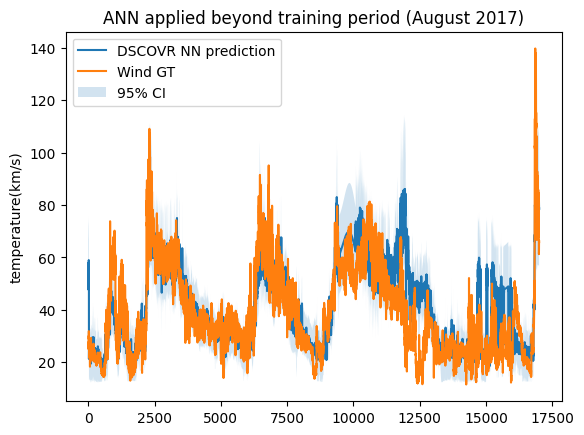

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_August_flat = np.ravel(upper_August)
lower_August_flat = np.ravel(lower_August)

# Plotting predictions
plt.plot(Predictions_August_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_August_)), upper_August_flat, lower_August_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_August_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (August 2017)')
plt.ylabel('temperature(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_temperature_August_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [86]:
mask_August=(Predictions_August_ >= 1) & (Predictions_August_<=120)
Predictions_August=Predictions_August_[mask_August]
Wind_input_August_warped=Wind_input_August_warped_[mask_August]

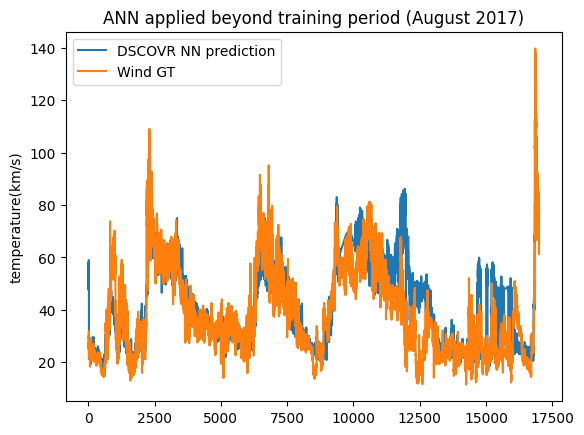

In [87]:
plt.plot(Predictions_August, label='DSCOVR NN prediction')
#plt.plot(Wind_input_August_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_August_warped, label='Wind GT')
plt.title('ANN applied beyond training period (August 2017)')
#plt.savefig('temperature_August_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

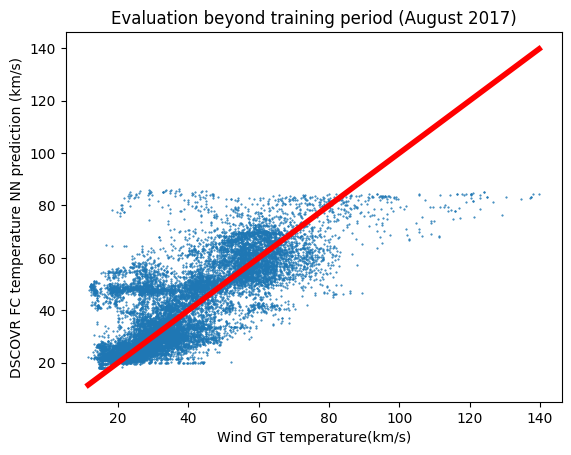

In [88]:
plt.plot(Wind_input_August_warped, Predictions_August, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (August 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_August_warped), np.amax(Wind_input_August_warped)],[np.amin(Wind_input_August_warped), np.amax(Wind_input_August_warped)], color='red', linewidth=4)
#plt.savefig('temperature-August_prediction_2017.png')

Mean err %:  7.966856435901432
Median err %:  5.16431969684476
stddev: 11.294808315173892


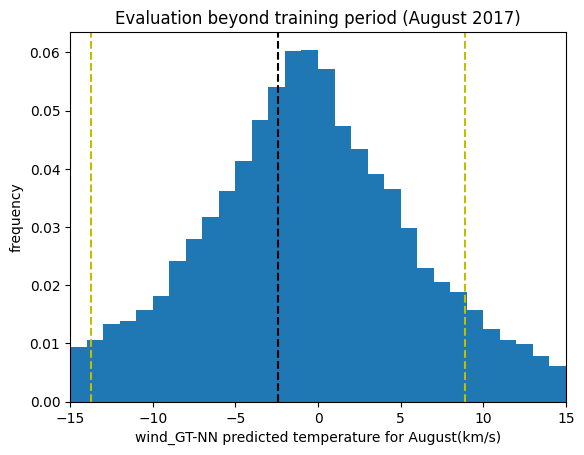

In [89]:
perr_NN_August = 100.*(Wind_input_August_warped-Predictions_August)/Wind_input_August_warped
tk_NN_August=np.where(Wind_input_August_warped > 0.1)
arr_perr_NN_August = (perr_NN_August)[tk_NN_August]
arr_regular_NN_August=(Wind_input_August_warped-Predictions_August)
m_NN_August=np.mean((arr_regular_NN_August))
sd_NN_August=np.std((arr_regular_NN_August))


plt.hist(arr_regular_NN_August, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_August, color='k', linestyle='dashed')
plt.axvline(m_NN_August+sd_NN_August, color='y', linestyle='dashed')
plt.axvline(m_NN_August-sd_NN_August, color='y', linestyle='dashed')

plt.xlim(-15,15)
#plt.yscale('log')
plt.title('Evaluation beyond training period (August 2017)')
plt.xlabel('wind_GT-NN predicted temperature for August(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-August_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_August)))
print('Median err %: ', np.median(abs(arr_regular_NN_August)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_August)

# September

In [90]:
DSCOVR_input_September, Wind_input_September=input_prep_func(ddata, Wind_Temp.values, 131000, 146000)
query1_September, template_September, alignment_wd_September, ind_September=DTW_function(wdata, ddata, 131000, 146000)
Wind_input_September_warped_=Wind_input_September[ind_September]

# Generating the standardized values of DSCOVR_input and Wind_input for September
DSCOVR_input_September_final=PredictorScalerFit.transform(DSCOVR_input_September)
#Wind_input_September_warped_final=TargetVarScalerFit.transform(Wind_input_September_warped)


prediction_distribution_September = bnn_model_full_Jan_Feb(DSCOVR_input_September_final)
prediction_mean_September = prediction_distribution_September.mean().numpy().tolist()
prediction_stdv_September = prediction_distribution_September.stddev().numpy()


Predictions_September_ = TargetVarScalerFit.inverse_transform(prediction_mean_September)
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
#Wind_input_test_orig_March = TargetVarScalerFit.inverse_transform(Wind_input_March_warped_2)
#Test_Data_March = PredictorScalerFit.inverse_transform(DSCOVR_input_March_final)


mask_September=((Predictions_September_ >= 1)&(Predictions_September_ <= 120))
Predictions_September=Predictions_September_[mask_September]
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
Wind_input_September_warped=Wind_input_September_warped_[mask_September]

In [91]:
prediction_stdv_September_=prediction_stdv_September*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_September = (Predictions_September_ + (1.96 * prediction_stdv_September_)).tolist()
lower_September = (Predictions_September_ - (1.96 * prediction_stdv_September_)).tolist()
prediction_stdv_September_ = prediction_stdv_September_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_September_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_September_[idx][0], 2)}, "
        f"95% CI: [{round(upper_September[idx][0], 2)} - {round(lower_September[idx][0], 2)}]"
        f" - Actual: {Wind_input_September_warped_[idx]}"
    )




Prediction mean: 80.19, stddev: 11.99, 95% CI: [103.69 - 56.68] - Actual: [65.9818]
Prediction mean: 79.31, stddev: 11.66, 95% CI: [102.16 - 56.47] - Actual: [58.58195]
Prediction mean: 81.14, stddev: 12.51, 95% CI: [105.66 - 56.63] - Actual: [59.0379]
Prediction mean: 81.13, stddev: 12.51, 95% CI: [105.65 - 56.61] - Actual: [62.8452]
Prediction mean: 80.85, stddev: 12.42, 95% CI: [105.2 - 56.51] - Actual: [59.21305]
Prediction mean: 81.39, stddev: 12.31, 95% CI: [105.51 - 57.26] - Actual: [62.7401]
Prediction mean: 81.31, stddev: 12.49, 95% CI: [105.79 - 56.84] - Actual: [59.8784]
Prediction mean: 80.62, stddev: 12.17, 95% CI: [104.48 - 56.76] - Actual: [58.76925]
Prediction mean: 79.73, stddev: 12.04, 95% CI: [103.33 - 56.13] - Actual: [55.3448]
Prediction mean: 81.0, stddev: 12.36, 95% CI: [105.22 - 56.78] - Actual: [57.3104]


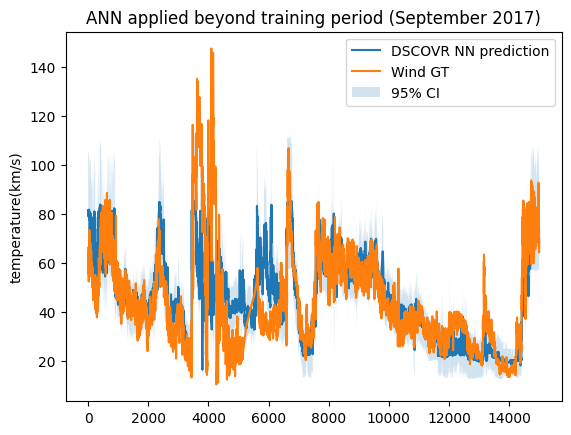

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_September_flat = np.ravel(upper_September)
lower_September_flat = np.ravel(lower_September)

# Plotting predictions
plt.plot(Predictions_September_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_September_)), upper_September_flat, lower_September_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_September_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (September 2017)')
plt.ylabel('temperature(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_temperature_September_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [93]:
mask_September=(Predictions_September_ >= 1) & (Predictions_September_<=120)
Predictions_September=Predictions_September_[mask_September]
Wind_input_September_warped=Wind_input_September_warped_[mask_September]

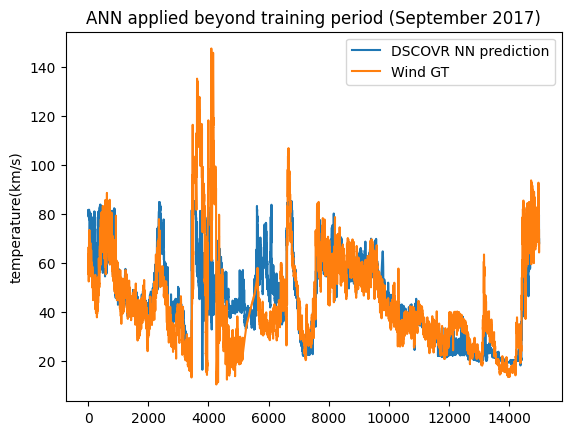

In [94]:
plt.plot(Predictions_September, label='DSCOVR NN prediction')
#plt.plot(Wind_input_September_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_September_warped, label='Wind GT')
plt.title('ANN applied beyond training period (September 2017)')
#plt.savefig('temperature_September_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

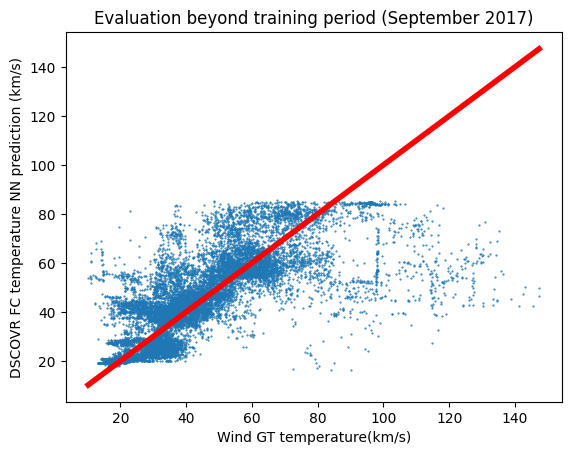

In [95]:
plt.plot(Wind_input_September_warped, Predictions_September, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (September 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_September_warped), np.amax(Wind_input_September_warped)],[np.amin(Wind_input_September_warped), np.amax(Wind_input_September_warped)], color='red', linewidth=4)
#plt.savefig('temperature-September_prediction_2017.png')

Mean err %:  9.656768401401497
Median err %:  6.123738783136433
stddev: 14.744931378076954


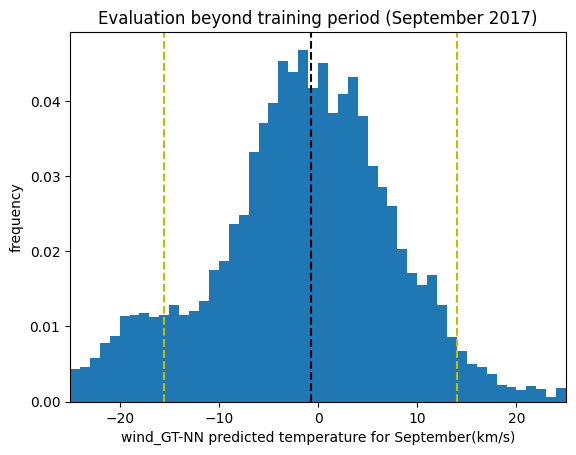

In [96]:
perr_NN_September = 100.*(Wind_input_September_warped-Predictions_September)/Wind_input_September_warped
tk_NN_September=np.where(Wind_input_September_warped > 0.1)
arr_perr_NN_September = (perr_NN_September)[tk_NN_September]
arr_regular_NN_September=(Wind_input_September_warped-Predictions_September)
m_NN_September=np.mean((arr_regular_NN_September))
sd_NN_September=np.std((arr_regular_NN_September))


plt.hist(arr_regular_NN_September, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_September, color='k', linestyle='dashed')
plt.axvline(m_NN_September+sd_NN_September, color='y', linestyle='dashed')
plt.axvline(m_NN_September-sd_NN_September, color='y', linestyle='dashed')

plt.xlim(-25,25)
#plt.yscale('log')
plt.title('Evaluation beyond training period (September 2017)')
plt.xlabel('wind_GT-NN predicted temperature for September(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-September_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_September)))
print('Median err %: ', np.median(abs(arr_regular_NN_September)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_September)

# October

In [97]:
DSCOVR_input_October, Wind_input_October=input_prep_func(ddata, Wind_Temp.values, 146000, 164000)
query1_October, template_October, alignment_wd_October, ind_October=DTW_function(wdata, ddata, 146000, 164000)
Wind_input_October_warped_=Wind_input_October[ind_October]

# Generating the standardized values of DSCOVR_input and Wind_input for September
DSCOVR_input_October_final=PredictorScalerFit.transform(DSCOVR_input_October)
#Wind_input_September_warped_final=TargetVarScalerFit.transform(Wind_input_September_warped)


prediction_distribution_October = bnn_model_full_Jan_Feb(DSCOVR_input_October_final)
prediction_mean_October = prediction_distribution_October.mean().numpy().tolist()
prediction_stdv_October = prediction_distribution_October.stddev().numpy()


Predictions_October_ = TargetVarScalerFit.inverse_transform(prediction_mean_October)
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
#Wind_input_test_orig_March = TargetVarScalerFit.inverse_transform(Wind_input_March_warped_2)
#Test_Data_March = PredictorScalerFit.inverse_transform(DSCOVR_input_March_final)


mask_October=((Predictions_October_ >= 1)&(Predictions_October_ <= 120))
Predictions_October=Predictions_October_[mask_October]
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
Wind_input_October_warped=Wind_input_October_warped_[mask_October]

In [98]:
prediction_stdv_October_=prediction_stdv_October*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_October = (Predictions_October_ + (1.96 * prediction_stdv_October_)).tolist()
lower_October = (Predictions_October_ - (1.96 * prediction_stdv_October_)).tolist()
prediction_stdv_October_ = prediction_stdv_October_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_October_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_October_[idx][0], 2)}, "
        f"95% CI: [{round(upper_October[idx][0], 2)} - {round(lower_October[idx][0], 2)}]"
        f" - Actual: {Wind_input_October_warped_[idx]}"
    )




Prediction mean: 70.26, stddev: 8.06, 95% CI: [86.05 - 54.46] - Actual: [66.324]
Prediction mean: 66.8, stddev: 7.28, 95% CI: [81.08 - 52.53] - Actual: [67.69225]
Prediction mean: 67.04, stddev: 7.32, 95% CI: [81.38 - 52.7] - Actual: [66.80005]
Prediction mean: 71.34, stddev: 8.35, 95% CI: [87.71 - 54.96] - Actual: [64.0484]
Prediction mean: 70.26, stddev: 8.12, 95% CI: [86.18 - 54.35] - Actual: [65.2618]
Prediction mean: 68.03, stddev: 7.56, 95% CI: [82.84 - 53.22] - Actual: [68.3793]
Prediction mean: 69.19, stddev: 7.78, 95% CI: [84.43 - 53.94] - Actual: [67.088]
Prediction mean: 68.0, stddev: 7.6, 95% CI: [82.89 - 53.12] - Actual: [65.9357]
Prediction mean: 67.74, stddev: 7.56, 95% CI: [82.56 - 52.92] - Actual: [63.5967]
Prediction mean: 68.25, stddev: 7.67, 95% CI: [83.28 - 53.23] - Actual: [62.9176]


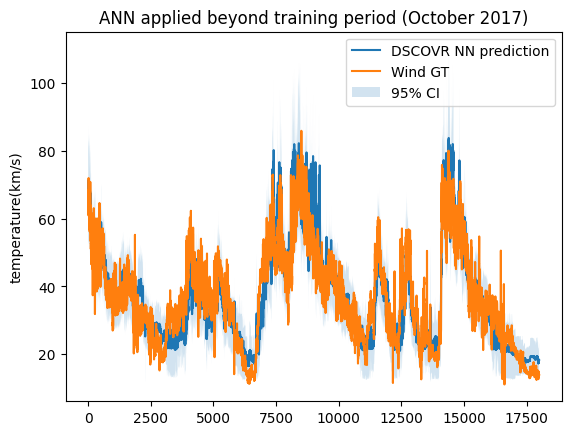

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_October_flat = np.ravel(upper_October)
lower_October_flat = np.ravel(lower_October)

# Plotting predictions
plt.plot(Predictions_October_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_October_)), upper_October_flat, lower_October_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_October_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (October 2017)')
plt.ylabel('temperature(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_temperature_October_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [100]:
mask_October=(Predictions_October_ >= 1) & (Predictions_October_<=120)
Predictions_October=Predictions_October_[mask_October]
Wind_input_October_warped=Wind_input_October_warped_[mask_October]

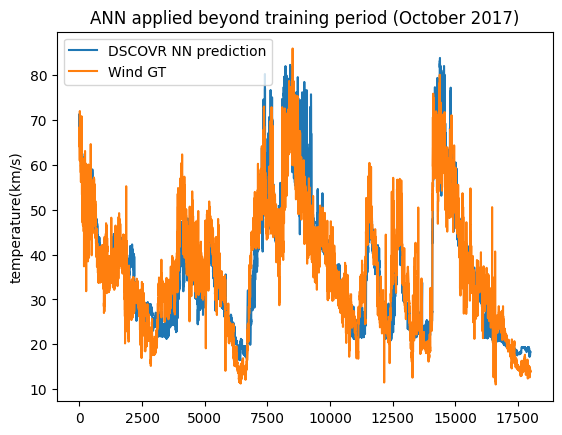

In [101]:
plt.plot(Predictions_October, label='DSCOVR NN prediction')
#plt.plot(Wind_input_October_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_October_warped, label='Wind GT')
plt.title('ANN applied beyond training period (October 2017)')
#plt.savefig('temperature_October_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

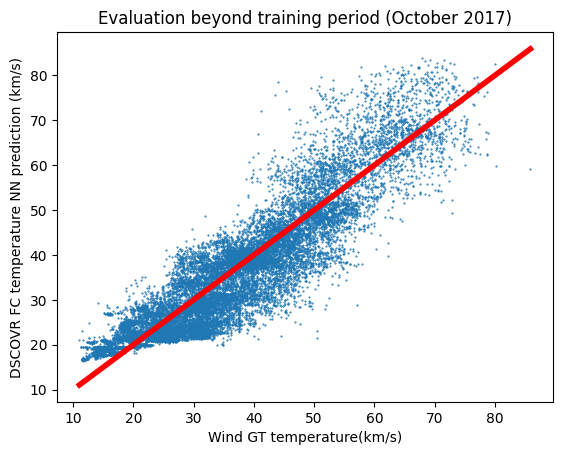

In [102]:
plt.plot(Wind_input_October_warped, Predictions_October, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (October 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_October_warped), np.amax(Wind_input_October_warped)],[np.amin(Wind_input_October_warped), np.amax(Wind_input_October_warped)], color='red', linewidth=4)
#plt.savefig('temperature-October_prediction_2017.png')

Mean err %:  4.770326924039942
Median err %:  3.8991442289036087
stddev: 6.100940613680996


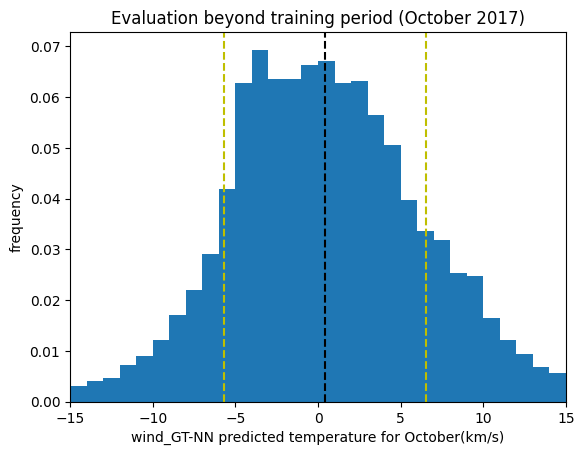

In [103]:
perr_NN_October = 100.*(Wind_input_October_warped-Predictions_October)/Wind_input_October_warped
tk_NN_October=np.where(Wind_input_October_warped > 0.1)
arr_perr_NN_October = (perr_NN_October)[tk_NN_October]
arr_regular_NN_October=(Wind_input_October_warped-Predictions_October)
m_NN_October=np.mean((arr_regular_NN_October))
sd_NN_October=np.std((arr_regular_NN_October))


plt.hist(arr_regular_NN_October, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_October, color='k', linestyle='dashed')
plt.axvline(m_NN_October+sd_NN_October, color='y', linestyle='dashed')
plt.axvline(m_NN_October-sd_NN_October, color='y', linestyle='dashed')

plt.xlim(-15,15)
#plt.yscale('log')
plt.title('Evaluation beyond training period (October 2017)')
plt.xlabel('wind_GT-NN predicted temperature for October(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-October_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_October)))
print('Median err %: ', np.median(abs(arr_regular_NN_October)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_October)

# November

In [104]:
DSCOVR_input_November, Wind_input_November=input_prep_func(ddata, Wind_Temp.values,164000, 180000)
query1_November, template_November, alignment_wd_November, ind_November=DTW_function(wdata, ddata, 164000, 180000)
Wind_input_November_warped_=Wind_input_November[ind_November]

# Generating the standardized values of DSCOVR_input and Wind_input for September
DSCOVR_input_November_final=PredictorScalerFit.transform(DSCOVR_input_November)
#Wind_input_September_warped_final=TargetVarScalerFit.transform(Wind_input_September_warped)


prediction_distribution_November = bnn_model_full_Jan_Feb(DSCOVR_input_November_final)
prediction_mean_November = prediction_distribution_November.mean().numpy().tolist()
prediction_stdv_November = prediction_distribution_November.stddev().numpy()


Predictions_November_ = TargetVarScalerFit.inverse_transform(prediction_mean_November)
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
#Wind_input_test_orig_March = TargetVarScalerFit.inverse_transform(Wind_input_March_warped_2)
#Test_Data_March = PredictorScalerFit.inverse_transform(DSCOVR_input_March_final)


mask_November=((Predictions_November_ >= 1)&(Predictions_November_ <= 120))
Predictions_November=Predictions_November_[mask_November]
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
Wind_input_November_warped=Wind_input_November_warped_[mask_November]

In [105]:
prediction_stdv_November_=prediction_stdv_November*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_November = (Predictions_November_ + (1.96 * prediction_stdv_November_)).tolist()
lower_November = (Predictions_November_ - (1.96 * prediction_stdv_November_)).tolist()
prediction_stdv_November_ = prediction_stdv_November_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_November_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_November_[idx][0], 2)}, "
        f"95% CI: [{round(upper_November[idx][0], 2)} - {round(lower_November[idx][0], 2)}]"
        f" - Actual: {Wind_input_November_warped_[idx]}"
    )




Prediction mean: 18.26, stddev: 2.24, 95% CI: [22.64 - 13.88] - Actual: [13.9569]
Prediction mean: 17.82, stddev: 2.04, 95% CI: [21.83 - 13.82] - Actual: [14.1723]
Prediction mean: 17.82, stddev: 2.04, 95% CI: [21.81 - 13.82] - Actual: [14.3702]
Prediction mean: 17.88, stddev: 2.07, 95% CI: [21.94 - 13.82] - Actual: [14.5909]
Prediction mean: 17.91, stddev: 2.08, 95% CI: [21.99 - 13.83] - Actual: [14.30575]
Prediction mean: 18.15, stddev: 2.18, 95% CI: [22.42 - 13.87] - Actual: [13.285]
Prediction mean: 18.22, stddev: 2.22, 95% CI: [22.56 - 13.88] - Actual: [13.1297]
Prediction mean: 18.21, stddev: 2.21, 95% CI: [22.55 - 13.87] - Actual: [13.6505]
Prediction mean: 18.3, stddev: 2.25, 95% CI: [22.71 - 13.88] - Actual: [13.0935]
Prediction mean: 18.29, stddev: 2.25, 95% CI: [22.7 - 13.88] - Actual: [13.0935]


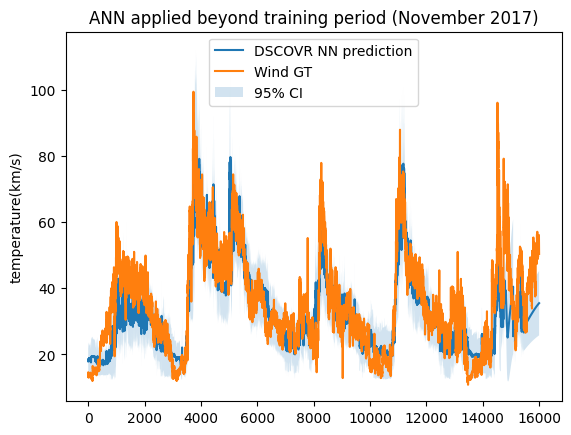

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_November_flat = np.ravel(upper_November)
lower_November_flat = np.ravel(lower_November)

# Plotting predictions
plt.plot(Predictions_November_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_November_)), upper_November_flat, lower_November_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_November_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (November 2017)')
plt.ylabel('temperature(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_temperature_November_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [107]:
mask_November=(Predictions_November_ >= 1) & (Predictions_November_<=120)
Predictions_November=Predictions_November_[mask_November]
Wind_input_November_warped=Wind_input_November_warped_[mask_November]

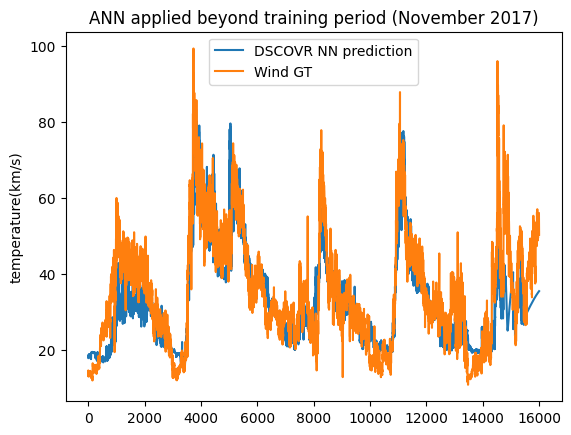

In [108]:
plt.plot(Predictions_November, label='DSCOVR NN prediction')
#plt.plot(Wind_input_November_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_November_warped, label='Wind GT')
plt.title('ANN applied beyond training period (November 2017)')
#plt.savefig('temperature_November_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

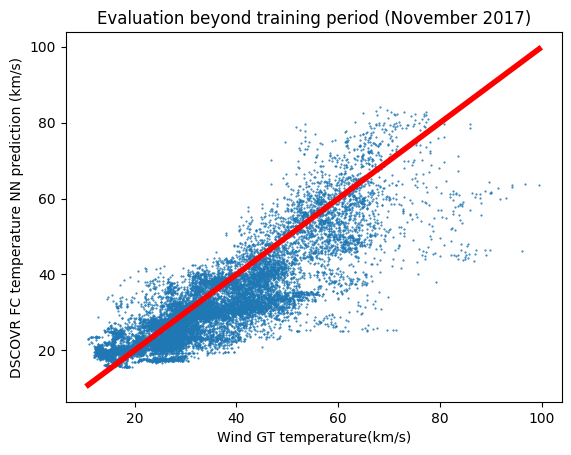

In [109]:
plt.plot(Wind_input_November_warped, Predictions_November, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (November 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_November_warped), np.amax(Wind_input_November_warped)],[np.amin(Wind_input_November_warped), np.amax(Wind_input_November_warped)], color='red', linewidth=4)
#plt.savefig('temperature-November_prediction_2017.png')

Mean err %:  6.065119214902961
Median err %:  4.633821354572387
stddev: 7.641170528020819


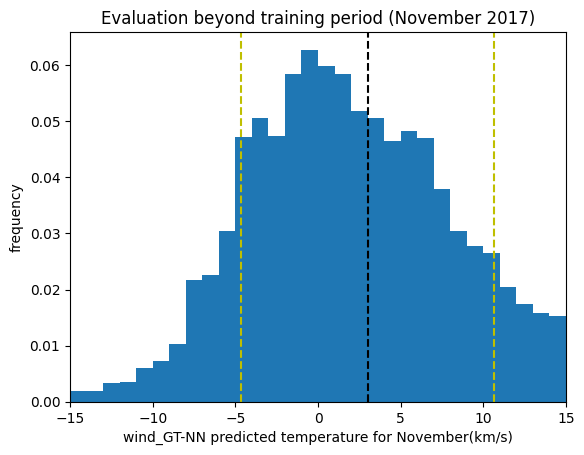

In [110]:
perr_NN_November = 100.*(Wind_input_November_warped-Predictions_November)/Wind_input_November_warped
tk_NN_November=np.where(Wind_input_November_warped > 0.1)
arr_perr_NN_November = (perr_NN_November)[tk_NN_November]
arr_regular_NN_November=(Wind_input_November_warped-Predictions_November)
m_NN_November=np.mean((arr_regular_NN_November))
sd_NN_November=np.std((arr_regular_NN_November))


plt.hist(arr_regular_NN_November, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_November, color='k', linestyle='dashed')
plt.axvline(m_NN_November+sd_NN_November, color='y', linestyle='dashed')
plt.axvline(m_NN_November-sd_NN_November, color='y', linestyle='dashed')

plt.xlim(-15,15)
#plt.yscale('log')
plt.title('Evaluation beyond training period (November 2017)')
plt.xlabel('wind_GT-NN predicted temperature for November(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-November_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_November)))
print('Median err %: ', np.median(abs(arr_regular_NN_November)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_November)

# December

In [111]:
DSCOVR_input_December, Wind_input_December=input_prep_func(ddata, Wind_Temp.values, 180000, 197100)
query1_December, template_December, alignment_wd_December, ind_December=DTW_function(wdata, ddata, 180000, 197100)
Wind_input_December_warped_=Wind_input_December[ind_December]

# Generating the standardized values of DSCOVR_input and Wind_input for September
DSCOVR_input_December_final=PredictorScalerFit.transform(DSCOVR_input_December)
#Wind_input_September_warped_final=TargetVarScalerFit.transform(Wind_input_September_warped)


prediction_distribution_December = bnn_model_full_Jan_Feb(DSCOVR_input_December_final)
prediction_mean_December = prediction_distribution_December.mean().numpy().tolist()
prediction_stdv_December = prediction_distribution_December.stddev().numpy()


Predictions_December_ = TargetVarScalerFit.inverse_transform(prediction_mean_December)
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
#Wind_input_test_orig_March = TargetVarScalerFit.inverse_transform(Wind_input_March_warped_2)
#Test_Data_March = PredictorScalerFit.inverse_transform(DSCOVR_input_March_final)


mask_December=((Predictions_December_ >= 1)&(Predictions_December_ <= 120))
Predictions_December=Predictions_December_[mask_December]
#Wind_input_March_warped_2=Wind_input_March_warped.reshape(-1,1)
Wind_input_December_warped=Wind_input_December_warped_[mask_December]

In [112]:
prediction_stdv_December_=prediction_stdv_December*TargetVarScalerFit.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_December = (Predictions_December_ + (1.96 * prediction_stdv_December_)).tolist()
lower_December = (Predictions_December_ - (1.96 * prediction_stdv_December_)).tolist()
prediction_stdv_December_ = prediction_stdv_December_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_December_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_December_[idx][0], 2)}, "
        f"95% CI: [{round(upper_December[idx][0], 2)} - {round(lower_December[idx][0], 2)}]"
        f" - Actual: {Wind_input_December_warped_[idx]}"
    )




Prediction mean: 36.73, stddev: 5.02, 95% CI: [46.56 - 26.9] - Actual: [46.03205]
Prediction mean: 36.74, stddev: 5.02, 95% CI: [46.57 - 26.9] - Actual: [46.3762]
Prediction mean: 36.75, stddev: 5.02, 95% CI: [46.58 - 26.91] - Actual: [47.1297]
Prediction mean: 36.75, stddev: 5.02, 95% CI: [46.59 - 26.92] - Actual: [46.39205]
Prediction mean: 36.76, stddev: 5.02, 95% CI: [46.6 - 26.92] - Actual: [46.9054]
Prediction mean: 36.77, stddev: 5.02, 95% CI: [46.61 - 26.93] - Actual: [48.3736]
Prediction mean: 36.78, stddev: 5.02, 95% CI: [46.62 - 26.94] - Actual: [47.5251]
Prediction mean: 36.78, stddev: 5.02, 95% CI: [46.63 - 26.94] - Actual: [50.6088]
Prediction mean: 36.79, stddev: 5.02, 95% CI: [46.64 - 26.95] - Actual: [49.8097]
Prediction mean: 36.8, stddev: 5.02, 95% CI: [46.65 - 26.95] - Actual: [51.0109]


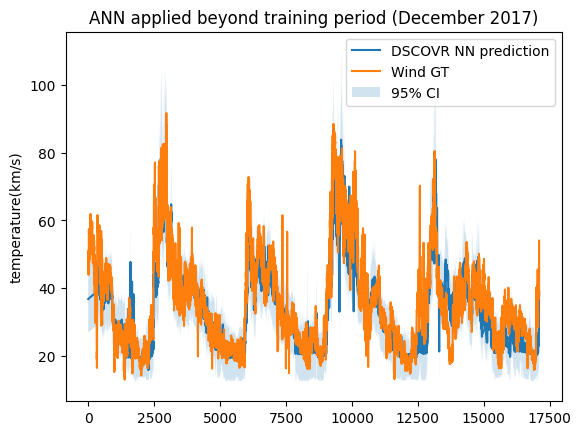

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_December_flat = np.ravel(upper_December)
lower_December_flat = np.ravel(lower_December)

# Plotting predictions
plt.plot(Predictions_December_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_December_)), upper_December_flat, lower_December_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_December_warped_, label='Wind GT')

plt.title('ANN applied beyond training period (December 2017)')
plt.ylabel('temperature(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_temperature_December_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [114]:
mask_December=(Predictions_December_ >= 1) & (Predictions_December_<=120)
Predictions_December=Predictions_December_[mask_December]
Wind_input_December_warped=Wind_input_December_warped_[mask_December]

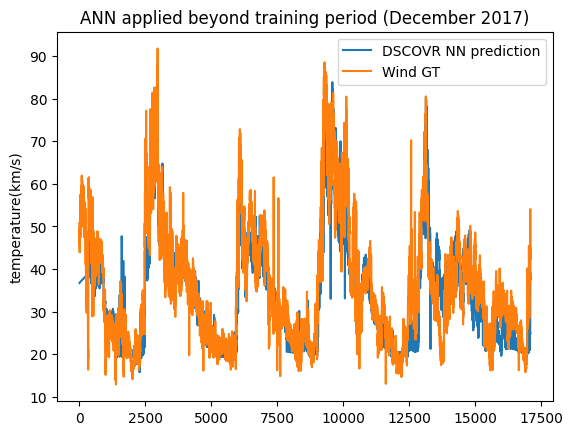

In [115]:
plt.plot(Predictions_December, label='DSCOVR NN prediction')
#plt.plot(Wind_input_December_warped, label='DSCOVR NN prediction')
plt.plot(Wind_input_December_warped, label='Wind GT')
plt.title('ANN applied beyond training period (December 2017)')
#plt.savefig('temperature_December_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('temperature(km/s)')
plt.legend()

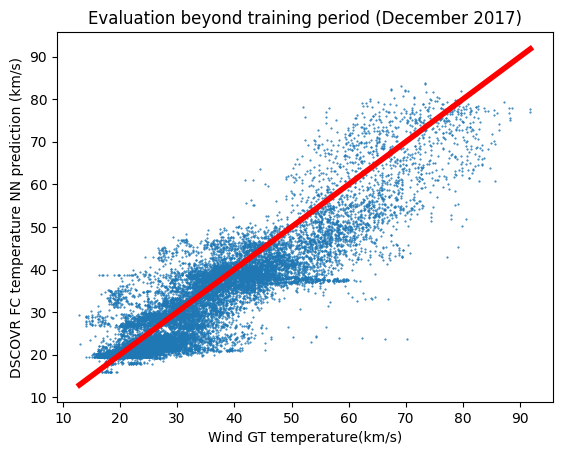

In [116]:
plt.plot(Wind_input_December_warped, Predictions_December, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT temperature(km/s)")
plt.ylabel("DSCOVR FC temperature NN prediction (km/s)")
plt.title('Evaluation beyond training period (December 2017)')
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_December_warped), np.amax(Wind_input_December_warped)],[np.amin(Wind_input_December_warped), np.amax(Wind_input_December_warped)], color='red', linewidth=4)
#plt.savefig('temperature-December_prediction_2017.png')

Mean err %:  4.948661169422331
Median err %:  3.693176338265035
stddev: 6.271915757973326


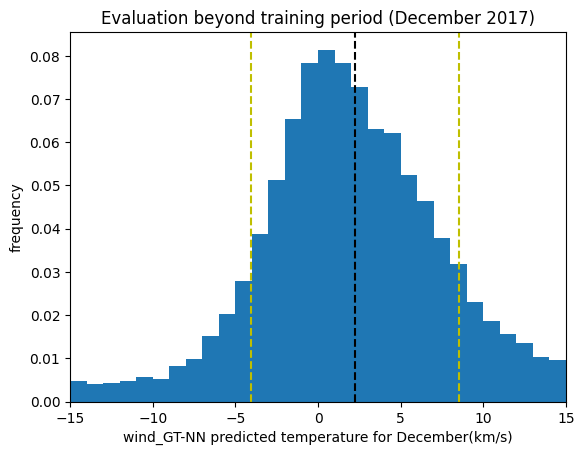

In [117]:
perr_NN_December = 100.*(Wind_input_December_warped-Predictions_December)/Wind_input_December_warped
tk_NN_December=np.where(Wind_input_December_warped > 0.1)
arr_perr_NN_December = (perr_NN_December)[tk_NN_December]
arr_regular_NN_December=(Wind_input_December_warped-Predictions_December)
m_NN_December=np.mean((arr_regular_NN_December))
sd_NN_December=np.std((arr_regular_NN_December))


plt.hist(arr_regular_NN_December, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_December, color='k', linestyle='dashed')
plt.axvline(m_NN_December+sd_NN_December, color='y', linestyle='dashed')
plt.axvline(m_NN_December-sd_NN_December, color='y', linestyle='dashed')

plt.xlim(-15,15)
#plt.yscale('log')
plt.title('Evaluation beyond training period (December 2017)')
plt.xlabel('wind_GT-NN predicted temperature for December(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-temperature-December_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_December)))
print('Median err %: ', np.median(abs(arr_regular_NN_December)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_December)

# RMSE & stddev values

In [118]:
stddev_A=[sd_NN_March, sd_NN_April, sd_NN_May, sd_NN_June, sd_NN_July, sd_NN_August, sd_NN_September, sd_NN_October, sd_NN_November, sd_NN_December]
stddev_A

[7.9707995641555724,
 10.37289848271806,
 10.154125159439703,
 7.999875514319805,
 13.390249572349369,
 11.294808315173892,
 14.744931378076954,
 6.100940613680996,
 7.641170528020819,
 6.271915757973326]

In [119]:
from sklearn.metrics import mean_squared_error
#mean_squared_error

#Jan_Feb_RMAE=np.sqrt(mean_squared_error(TestingData_GT.tolist(), TestingData_Predicted.tolist()))
March_RMAE=np.sqrt(mean_squared_error(Wind_input_March_warped.tolist(), Predictions_March.tolist()))

April_RMAE=np.sqrt(mean_squared_error(Wind_input_April_warped.tolist(), Predictions_April.tolist()))
May_RMAE=np.sqrt(mean_squared_error(Wind_input_May_warped.tolist(), Predictions_May.tolist()))
June_RMAE=np.sqrt(mean_squared_error(Wind_input_June_warped.tolist(), Predictions_June.tolist()))
July_RMAE=np.sqrt(mean_squared_error(Wind_input_July_warped.tolist(), Predictions_July.tolist()))
August_RMAE=np.sqrt(mean_squared_error(Wind_input_August_warped.tolist(), Predictions_August.tolist()))
September_RMAE=np.sqrt(mean_squared_error(Wind_input_September_warped.tolist(), Predictions_September.tolist()))
October_RMAE=np.sqrt(mean_squared_error(Wind_input_October_warped.tolist(), Predictions_October.tolist()))
November_RMAE=np.sqrt(mean_squared_error(Wind_input_November_warped.tolist(), Predictions_November.tolist()))
December_RMAE=np.sqrt(mean_squared_error(Wind_input_December_warped.tolist(), Predictions_December.tolist()))

In [120]:
RMSE_A=[March_RMAE, April_RMAE, May_RMAE, June_RMAE, July_RMAE, August_RMAE, September_RMAE, October_RMAE, November_RMAE, December_RMAE]
np.average([March_RMAE, April_RMAE, May_RMAE, June_RMAE, July_RMAE, August_RMAE, September_RMAE, October_RMAE, November_RMAE, December_RMAE])

9.799074514195432

In [121]:
range_wind=pd.read_csv('/Users/ssxguser/Downloads/rangeofwindfiles/range_wind_temperature_2017.csv')
def calculate_percentage_rmse(rmse, target_range):
    percentage_rmse = (rmse / target_range) * 100
    return percentage_rmse

percent_rmse = calculate_percentage_rmse(np.average(RMSE_A),  range_wind['range_Wind'][0])
print(percent_rmse)


9.607710680363006


In [122]:
range_wind['range_Wind'][0]

101.99177348484848

In [123]:
(9.64/101.99177348484848)*100

9.451742695142059

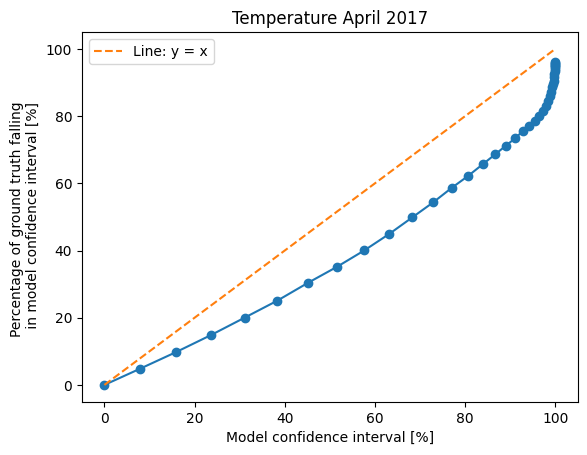

In [124]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Assuming the necessary variables are already defined
nsigma = np.arange(40) / 10
percent_in_range = []

for i in nsigma:
    upper = TargetVarScalerFit.inverse_transform(prediction_mean_April + i * prediction_stdv_April)
    lower = TargetVarScalerFit.inverse_transform(prediction_mean_April - i * prediction_stdv_April)
    mask = (Wind_input_April_warped_ < upper) & (Wind_input_April_warped_ > lower)
    fraction = np.sum(mask) / len(mask)
    percent_in_range.append(100 * fraction)

x_values=200 * (stats.norm.cdf(nsigma, loc=0, scale=1) - 0.5)
plt.plot(x_values, percent_in_range, '-o')
m=1
b=0
y_line= m*x_values+b
plt.plot(x_values, y_line, label=f'Line: y = x', linestyle='--')

plt.ylabel('Percentage of ground truth falling \n in model confidence interval [%]')
plt.xlabel('Model confidence interval [%]')
plt.title('Temperature April 2017')
#plt.show()
plt.legend()
plt.savefig('Final_CI_linear_plot_temperature_2017.png')

#2018
range_wind=pd.read_csv('/Users/ssxguser/Downloads/rangeofwindfiles/range_wind_temperature_2018.csv')
def calculate_percentage_rmse(rmse, target_range):
    percentage_rmse = (rmse / target_range) * 100
    return percentage_rmse

percent_rmse = calculate_percentage_rmse(np.average(RMSE_A),  range_wind['range_Wind'][0])
print(percent_rmse)